# Estimating intersection with HyperLogLog
In this notebook we will explore three different methods to estimate the intersection of two sets using [HyperLogLog counters](https://github.com/LucaCappelletti94/hyperloglog-rs). The first method is usually referred to as [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle), the second method computes a new HyperLogLog counter from the minimum of the two counters (somewhat inspired by how [MinHash](https://github.com/LucaCappelletti94/minhash-rs) operates) and the third method uses the [Maximum Likelihood Estimation (MLE) to have a better estimate of the intersection cardinality](https://oertl.github.io/hyperloglog-sketch-estimation-paper/paper/paper.pdf). But let's start from the very basics!

## What is the cardinality of a set?
The cardinality of a set is the number of elements in the set. For example, the cardinality of the set `{1, 2, 3}` is `3`. The cardinality of a set can be computed by iterating over the elements of the set and counting them. If the set is very large, it is not possible to store it in memory and therefore we need to use a different approach.

### Sets where HyperLogLog is needed to estimate the cardinality
Suppose you are a company that crawls the internet, such as Google. You want to know the unique number of pages you have visited, but it is not possible to store into an hash-based set all of these pages, because there are too many of them. In this case, you can use a probabilistic data structure such as a HyperLogLog counter to estimate the cardinality of the set of pages you have visited.

## What is the intersection of two sets?
The intersection of two sets is the set of elements that are present in both sets. For example, the intersection of the sets `{1, 2, 3}` and `{2, 3, 4}` is `{2, 3}`. If the sets are very large, it is not possible to store them in memory and therefore we need to use a different approach, that stores the structure of the two sets implicitly, without storing the elements of the sets themselves.

### Sets where HyperLogLog is needed to estimate the intersection
Suppose your company has been running multiple crawlers, and you want to know whether two crawlers are now colliding with each other and exploring the same pages. As before, we cannot store the sets of pages visited by the two crawlers in memory, and therefore we need to use a probabilistic data structure such as a HyperLogLog counter to estimate the intersection of the two sets.

## But what exactly is an HyperLogLog counter?
An HyperLogLog counter is a probabilistic data structure used to estimate the cardinality of a set. It is based on the observation that the cardinality of a set can be estimated by the maximum number of leading zeros in the binary representation of the hashes of the elements of the set. The HyperLogLog counter is a data structure that stores the maximum number of leading zeros for a set of hashes. The counter is initialized with a number of bits, which determines the maximum number of leading zeros that can be stored. The counter is then updated with the hashes of the elements of the set. The estimate of the cardinality is then given by the harmonic mean of the values stored in the counter. HyperLogLog counters can be used to compute the cardinality of the union of two sets by taking the maximum of the values stored in the two counters, and therefore we can also compute the intersection of two sets. The methods we can employ to estimate the intersection of two sets using HyperLogLog counters are the subject of this notebook.

[Learn more about HyperLogLog in the original paper here](https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/40671.pdf).

Here follows an illustration of how an element to be counted is inserted in the HyperLogLog:

![HyperLogLog insertion of an element](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/registers_hll.png?raw=true)

### Inclusion-exclusion principle
The first method we will explore is the [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle). The inclusion-exclusion principle states that the cardinality of the union of two sets is given by the sum of the cardinality of the two sets minus the cardinality of the intersection of the two sets. Therefore, we can estimate the cardinality of the intersection of two sets by computing the cardinality of the union of the two sets and subtracting the cardinality of the two sets. The cardinality of the union of two sets can be computed using the HyperLogLog counter as described above, and therefore we can estimate the cardinality of the intersection of two sets using the inclusion-exclusion principle.

![Inclusion-exclusion principle](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/intersection.jpg?raw=true)

### Minimum of two counters
An approach we include for completeness sake, as I have encountered it being used in the wild, is to estimate the HyperLogLog counter representing the intersection of the two sets by computing the minimum register-wise. The cardinality of this new HyperLogLog counter is then meant to estimate the cardinality of the intersection of the two sets. This approach is inspired by how [MinHash](https://github.com/LucaCappelletti94/minhash-rs) operates. We will provide in the benchmarks that, while this approach in the MinHash datastructure can provide a good estimate of the intersection cardinality, it is not viable for HyperLogLog counters.

![Min intersection](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/min_intersection.png?raw=true)

#### How MinHash operates
While we exclude MinHash from the current benchmark lineup, as we have already [extensively benchmarked MinHash in the past](https://github.com/LucaCappelletti94/minhash-rs/blob/main/MinHash%20Jaccard%20benchmarks.ipynb), I still wanted to provide a gist of how the data structure operates. MinHash is a probabilistic data structure that estimates the Jaccard similarity between two sets. The Jaccard similarity between two sets is the cardinality of the intersection of the two sets divided by the cardinality of the union of the two sets. The MinHash data structure is initialized with a number of hash functions, which determines the number of words that will be used to store the hashes of the elements of the set. All words are initialized with the maximum value that you can store in that word ([which in fancy talk is referred to as a Mersenne prime number](https://en.wikipedia.org/wiki/Mersenne_prime)). When you intend to insert a new element, you compute all of the hashes for the element and update the words where the hash of the element is the minimum. The estimate of the Jaccard similarity is then given by the number of equal values in the same position of the two words divided by the number of hash functions.

![MinHash diagram](https://github.com/LucaCappelletti94/minhash-rs/raw/main/minhash_diagram.jpg?raw=true)

### Maximum Likelihood Estimation
Finally, we will explore the Maximum Likelihood Estimation (MLE) approach. You can [read the details of this approach in the original paper by Otmar Ertl here](https://oertl.github.io/hyperloglog-sketch-estimation-paper/paper/paper.pdf). THE MLE approach to jointly estimate the intersection of two HyperLogLog counters is based on the principle of finding parameter values that maximize the likelihood of the observed data. In this context, the data consists of the register values of two HyperLogLog counters representing two sets. You can delve into my actual Rust implementation [here](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/16af131fdc3c80d46be3a8da4ea677c502d33f6d/src/hyperloglog_multiplicities.rs#L382).

We need to employ techniques such as numerical optimization methods (e.g., gradient ascent) are applied to find the parameter values that maximize the log-likelihood function. These techniques iteratively adjust the parameter values to approach the maximum likelihood estimates. In this implementation we employ an [Adam Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) to find the maximum likelihood estimates of the parameters.

We iterate up until the gradient updates are smaller than a certain threshold ($10^{-error}$), or until we reach a maximum number of iterations, which in these experiments is set to 100k. In this benchmark, we explore how the error threshold affects the accuracy of the estimate and the time required for convergence.

## The experimental setup
We will compare the three methods described above on $10000$ random couples of sets of up to $100000$ elements each. The sets are generated by sampling from a uniform distribution. We will compare the accuracy of the estimates of the intersection cardinality and the time required to compute the estimates. We will also explore how the error threshold affects the accuracy of the estimate and the time required for convergence.

### Running the experiment
The data here reported was computed by running the following line:

```bash
RUSTFLAGS="-C target-cpu=native" cargo test --test test_intersection --release --features=std
```

## Loading the results
We load up the results and group them up by the precision and bits employed. We will compute the time requirements and absolute error mean, median and standard deviation of the results across the $10000$ runs.

In [268]:
# import os
# from glob import glob

# paths = glob("intersection_tests/intersection_cardinality_benchmark_kernel_fused3_*.tsv")

# for path in paths:
#     os.remove(path)

In [290]:
import os
import pandas as pd
from tqdm.auto import tqdm
from glob import glob

path = "intersection_benchmarks_kernel_fused3.tsv.gz"

if not os.path.exists(path):
    paths = glob("intersection_tests/intersection_cardinality_benchmark_kernel_fused3_*.tsv")
    
    dfs = []
    
    for updated_path in tqdm(paths, leave=False, desc="Aligning files"):
        older_path = updated_path.replace("kernel_fused3_", "")
        previous_df = pd.read_csv(older_path,  sep="\t")
        try:
            updated_df = pd.read_csv(updated_path,  sep="\t")
        except Exception as e:
            os.remove(updated_path)
            raise e
            
        if previous_df.shape[0] != updated_df.shape[0]:
            # It means that this document is being written.
            continue
        # We check that the exact estimates are matching
        assert (updated_df["exact"] == previous_df["exact"]).all()
            
        # We update the column names
        updated_df.columns = [
            column.replace("mle", "kernel_fused_mle")
            for column in updated_df.columns
        ]
        
        # We attach the new columns to the df
        updated_df = updated_df[[
            column
            for column in updated_df.columns
            if "kernel_fused_mle" in column
        ]]
        
        df = pd.concat(
            [
                previous_df,
                updated_df
            ],
            axis=1
        )
        
        dfs.append(df)
    
    combined = pd.concat(dfs)    
    #combined.reset_index(drop=True).to_csv(path, sep="\t", index=False, compression="gzip")
    df = combined
    
# First we will load the data and compute the memory usage of each parametrization.
#df = pd.read_csv(path, sep="\t")
df["memory"] = 2**df.precision * df.bits

estimations = [
    "inclusion_exclusion",
    "hll_min"
] + [
    column
    for column in df.columns
    if "mle" in column and "time" not in column
]

errors = []
times = [
    column
    for column in df.columns
    if "time" in column
]

# Then we compute the errors for each estimation.
for column in estimations:
    new_column = f"{column}_error"
    df[new_column] = (df.exact - df[column])**2
    errors.append(new_column)

# And finally we compute the mean, median and standard deviation of the squared errors and times.
data_hll = df.groupby(["precision", "bits", "memory"])[[*errors, *times]].agg(["mean", "median", "std"])
data_hll = data_hll.reset_index()
data_hll

Aligning files:   0%|          | 0/10000 [00:00<?, ?it/s]

precision bits  memory inclusion_exclusion_error                \
                                               mean        median   
0          4    4      64              1.707200e+07  4.148526e+06   
1          4    5      80              1.721715e+07  4.183000e+06   
2          4    6      96              1.721715e+07  4.183000e+06   
3          5    4     128              1.208500e+07  3.046975e+06   
4          5    5     160              1.207622e+07  3.023306e+06   
5          5    6     192              1.207622e+07  3.023306e+06   
6          6    4     256              7.088198e+06  1.712065e+06   
7          6    5     320              7.093372e+06  1.718342e+06   
8          6    6     384              7.093375e+06  1.718342e+06   
9          7    4     512              3.455597e+06  8.155183e+05   
10         7    5     640              3.456679e+06  8.161287e+05   
11         7    6     768              3.456679e+06  8.161287e+05   
12         8    4    1024              1.915569e+06  4.615663e+05   
13         8    5    1280              1.915584e+06  4.615663e+05   
14         8    6    1536              1.915584e+06  4.615663e+05   
15         9    4    2048              1.168601e+06  2.448933e+05   
16         9    5    2560              1.168612e+06  2.448933e+05   
17         9    6    3072              1.168612e+06  2.448933e+05   
18        10    4    4096              5.571742e+05  1.274961e+05   
19        10    5    5120              5.571742e+05  1.274961e+05   
20        10    6    6144              5.571742e+05  1.274961e+05   
21        11    4    8192              3.115942e+05  7.886661e+04   
22        11    5   10240              3.115926e+05  7.887111e+04   
23        11    6   12288              3.115926e+05  7.887111e+04   
24        12    4   16384              1.472590e+05  3.673202e+04   
25        12    5   20480              1.472586e+05  3.673210e+04   
26        12    6   24576              1.472586e+05  3.673210e+04   
27        13    4   32768              7.639276e+04  1.598051e+04   
28        13    5   40960              7.639257e+04  1.598051e+04   
29        13    6   49152              7.639257e+04  1.598051e+04   
30        14    4   65536              2.586554e+04  5.662562e+03   
31        14    5   81920              2.586554e+04  5.662562e+03   
32        14    6   98304              2.586554e+04  5.662562e+03   
33        15    4  131072              1.291171e+04  3.388986e+03   
34        15    5  163840              1.291171e+04  3.388986e+03   
35        15    6  196608              1.291171e+04  3.388986e+03   
36        16    4  262144              6.004160e+03  1.279042e+03   
37        16    5  327680              6.004201e+03  1.279042e+03   
38        16    6  393216              6.004204e+03  1.279042e+03   

                 hll_min_error                               mle_1_error  ...  \
             std          mean        median           std          mean  ...   
0   3.700265e+07  2.396035e+07  9.950849e+06  3.891368e+07  1.973391e+07  ...   
1   3.740763e+07  2.400433e+07  9.963303e+06  3.903463e+07  1.942326e+07  ...   
2   3.740763e+07  2.400433e+07  9.963303e+06  3.903463e+07  1.942326e+07  ...   
3   2.396917e+07  3.342046e+07  1.644921e+07  4.391020e+07  1.040897e+07  ...   
4   2.395306e+07  3.342944e+07  1.644921e+07  4.392663e+07  1.043517e+07  ...   
5   2.395306e+07  3.342944e+07  1.644921e+07  4.392663e+07  1.043517e+07  ...   
6   1.454244e+07  3.230831e+07  1.716884e+07  3.925834e+07  6.953203e+06  ...   
7   1.455624e+07  3.232791e+07  1.718281e+07  3.928309e+07  6.957887e+06  ...   
8   1.455625e+07  3.232791e+07  1.718281e+07  3.928309e+07  6.957887e+06  ...   
9   7.493698e+06  2.422817e+07  1.219932e+07  2.939363e+07  3.448246e+06  ...   
10  7.498147e+06  2.423050e+07  1.220034e+07  2.939632e+07  3.446493e+06  ...   
11  7.498145e+06  2.423050e+07  1.220034e+07  2.939632e+07  3.446493e+06  ...   
12  4.041713e+06  2.935354e+07  1.66640

## Which method is most accurate?
Now to answer the question that brought you here: what is the most accurate method? We compute the rate between the different methods, and see how they perform for the same amount of memory required.

In [291]:
methods = []

for metric in ("mean", "median"):
    rate_ie_mle = data_hll.inclusion_exclusion_error[metric] / data_hll.mle_3_error[metric]
    rate_ie_mle_updated = data_hll.inclusion_exclusion_error[metric] / data_hll.kernel_fused_mle_3_error[metric]
    rate_mle_mle_updated = data_hll.mle_3_error[metric] / data_hll.kernel_fused_mle_3_error[metric]
    rate_min_mle = data_hll.hll_min_error[metric] / data_hll.mle_3_error[metric]
    rate_min_ie = data_hll.hll_min_error[metric] / data_hll.inclusion_exclusion_error[metric]

    methods.append(pd.DataFrame({
        "metric": metric,
        "MSE rate max": rate_ie_mle.max(),
        "MSE rate min": rate_ie_mle.min(),
        "MSE rate median": rate_ie_mle.median(),
        "MSE rate mean": rate_ie_mle.mean(),
        "first_method": "INCLUSION / EXCLUSION",
        "second_method": "MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "MSE rate max": rate_ie_mle_updated.max(),
        "MSE rate min": rate_ie_mle_updated.min(),
        "MSE rate median": rate_ie_mle_updated.median(),
        "MSE rate mean": rate_ie_mle_updated.mean(),
        "first_method": "INCLUSION / EXCLUSION",
        "second_method": "KERNEL FUSED MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "MSE rate max": rate_mle_mle_updated.max(),
        "MSE rate min": rate_mle_mle_updated.min(),
        "MSE rate median": rate_mle_mle_updated.median(),
        "MSE rate mean": rate_mle_mle_updated.mean(),
        "first_method": "MLE",
        "second_method": "KERNEL FUSED MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "MSE rate max": rate_min_ie.max(),
        "MSE rate min": rate_min_ie.min(),
        "MSE rate median": rate_min_ie.median(),
        "MSE rate mean": rate_min_ie.mean(),
        "first_method": "HLL MIN",
        "second_method": "INCLUSION / EXCLUSION"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "MSE rate max": rate_min_mle.max(),
        "MSE rate min": rate_min_mle.min(),
        "MSE rate median": rate_min_mle.median(),
        "MSE rate mean": rate_min_mle.mean(),
        "first_method": "HLL MIN",
        "second_method": "MLE"
    }, index=[0]))

methods = pd.concat(methods).reset_index(drop=True)
methods

,metric,MSE rate max,MSE rate min,MSE rate median,MSE rate mean,first_method,second_method
0,mean,2.129534,1.018846,1.480448,1.527551,INCLUSION / EXCLUSION,MLE
1,mean,2.129994,1.030862,1.482548,1.528874,INCLUSION / EXCLUSION,KERNEL FUSED MLE
2,mean,1.011794,0.998448,1.000317,1.001204,MLE,KERNEL FUSED MLE
3,mean,1131.378491,1.394210,57.320430,313.608162,HLL MIN,INCLUSION / EXCLUSION
4,mean,2337.882165,1.429938,87.148078,566.690406,HLL MIN,MLE
5,median,2.417396,1.095243,1.771338,1.835043,INCLUSION / EXCLUSION,MLE
6,median,2.415636,1.085879,1.775669,1.833150,INCLUSION / EXCLUSION,KERNEL FUSED MLE
7,median,1.008582,0.979819,0.999379,0.998574,MLE,KERNEL FUSED MLE
8,median,2196.814963,2.381856,143.683124,631.853884,HLL MIN,INCLUSION / EXCLUSION
9,median,4169.014730,2.627101,285.696124,1305.941128,HLL MIN,MLE


It appears that the worst performing method, by far, is the minimum of two counters. The inclusion-exclusion principle using the HyperLogLog++ is quite close to the MLE method, which ultimately always performs better than the inclusion-exclusion principle. IN fact, the MLE can be up to twice as accurate as the inclusion-exclusion principle, and in average it is $1.5$ times more accurate.

## Which method is the fastest?
We now explore which method is the fastest. We compute the rate between the different methods, and see how they perform for the same amount of memory required.

In [292]:
methods = []

for metric in ("mean", "median"):
    rate_ie_mle = data_hll.time_inclusion_exclusion[metric] / data_hll.time_mle_3[metric]
    rate_ie_updated_mle = data_hll.time_inclusion_exclusion[metric] / data_hll.time_kernel_fused_mle_3[metric]
    rate_mle_ie = data_hll.time_mle_3[metric] / data_hll.time_inclusion_exclusion[metric]
    rate_mle_updated_mle = data_hll.time_mle_3[metric] / data_hll.time_kernel_fused_mle_3[metric]
    rate_updated_mle_ie = data_hll.time_kernel_fused_mle_3[metric] / data_hll.time_inclusion_exclusion[metric]
    rate_min_mle = data_hll.time_hll_min[metric] / data_hll.time_mle_3[metric]
    rate_min_ie = data_hll.time_hll_min[metric] / data_hll.time_inclusion_exclusion[metric]

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_ie_mle.max(),
        "rate min": rate_ie_mle.min(),
        "rate median": rate_ie_mle.median(),
        "rate mean": rate_ie_mle.mean(),
        "first_method": "INCLUSION / EXCLUSION",
        "second_method": "MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_ie_updated_mle.max(),
        "rate min": rate_ie_updated_mle.min(),
        "rate median": rate_ie_updated_mle.median(),
        "rate mean": rate_ie_updated_mle.mean(),
        "first_method": "INCLUSION / EXCLUSION",
        "second_method": "KERNEL FUSED MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_mle_ie.max(),
        "rate min": rate_mle_ie.min(),
        "rate median": rate_mle_ie.median(),
        "rate mean": rate_mle_ie.mean(),
        "first_method": "MLE",
        "second_method": "INCLUSION / EXCLUSION"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_mle_updated_mle.max(),
        "rate min": rate_mle_updated_mle.min(),
        "rate median": rate_mle_updated_mle.median(),
        "rate mean": rate_mle_updated_mle.mean(),
        "first_method": "MLE",
        "second_method": "KERNEL FUSED MLE"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_updated_mle_ie.max(),
        "rate min": rate_updated_mle_ie.min(),
        "rate median": rate_updated_mle_ie.median(),
        "rate mean": rate_updated_mle_ie.mean(),
        "first_method": "KERNEL FUSED MLE",
        "second_method": "INCLUSION / EXCLUSION"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_min_ie.max(),
        "rate min": rate_min_ie.min(),
        "rate median": rate_min_ie.median(),
        "rate mean": rate_min_ie.mean(),
        "first_method": "HLL MIN",
        "second_method": "INCLUSION / EXCLUSION"
    }, index=[0]))

    methods.append(pd.DataFrame({
        "metric": metric,
        "rate max": rate_min_mle.max(),
        "rate min": rate_min_mle.min(),
        "rate median": rate_min_mle.median(),
        "rate mean": rate_min_mle.mean(),
        "first_method": "HLL MIN",
        "second_method": "MLE"
    }, index=[0]))

methods = pd.concat(methods).reset_index(drop=True)
methods

,metric,rate max,rate min,rate median,rate mean,first_method,second_method
0,mean,0.095847,0.001106,0.018065,0.027910,INCLUSION / EXCLUSION,MLE
1,mean,0.736062,0.074929,0.538640,0.470765,INCLUSION / EXCLUSION,KERNEL FUSED MLE
2,mean,903.772807,10.433307,55.357055,128.836587,MLE,INCLUSION / EXCLUSION
3,mean,67.718409,6.951457,27.352728,30.200006,MLE,KERNEL FUSED MLE
4,mean,13.346043,1.358582,1.856528,3.076277,KERNEL FUSED MLE,INCLUSION / EXCLUSION
5,mean,1.030781,0.980503,0.995343,0.998549,HLL MIN,INCLUSION / EXCLUSION
6,mean,0.096388,0.001097,0.018475,0.027875,HLL MIN,MLE
7,median,0.326082,0.012880,0.134195,0.134977,INCLUSION / EXCLUSION,MLE
8,median,0.758752,0.189963,0.606843,0.562679,INCLUSION / EXCLUSION,KERNEL FUSED MLE
9,median,77.641861,3.066717,7.451862,14.843111,MLE,INCLUSION / EXCLUSION


We find that the HLL minimum and the inclusion-exclusion methods are roughly the same speed, while the MLE method is massively slower than the inclusion-exclusion method. The MLE method is up to $900$ and $77$ times slower than the inclusion-exclusion method in mean and median respectively. The MLE method is at least $10$ and $3$ times slower than the inclusion-exclusion method in mean and median respectively. Finally, the MLE method is, in median, at least $55$ and $7$ times slower than the inclusion-exclusion method in mean and median respectively.

*The MLE method, while in average about 1.5 times better than the inclusion-exclusion methods, is significantly slower than the inclusion-exclusion method.*

*Using as MLE error 3 leads to the best performance, considering time requirements and accuracy achieved.*

## MSE per memory requirements
Let's take a look at the performance of the methods when we consider the memory requirements.

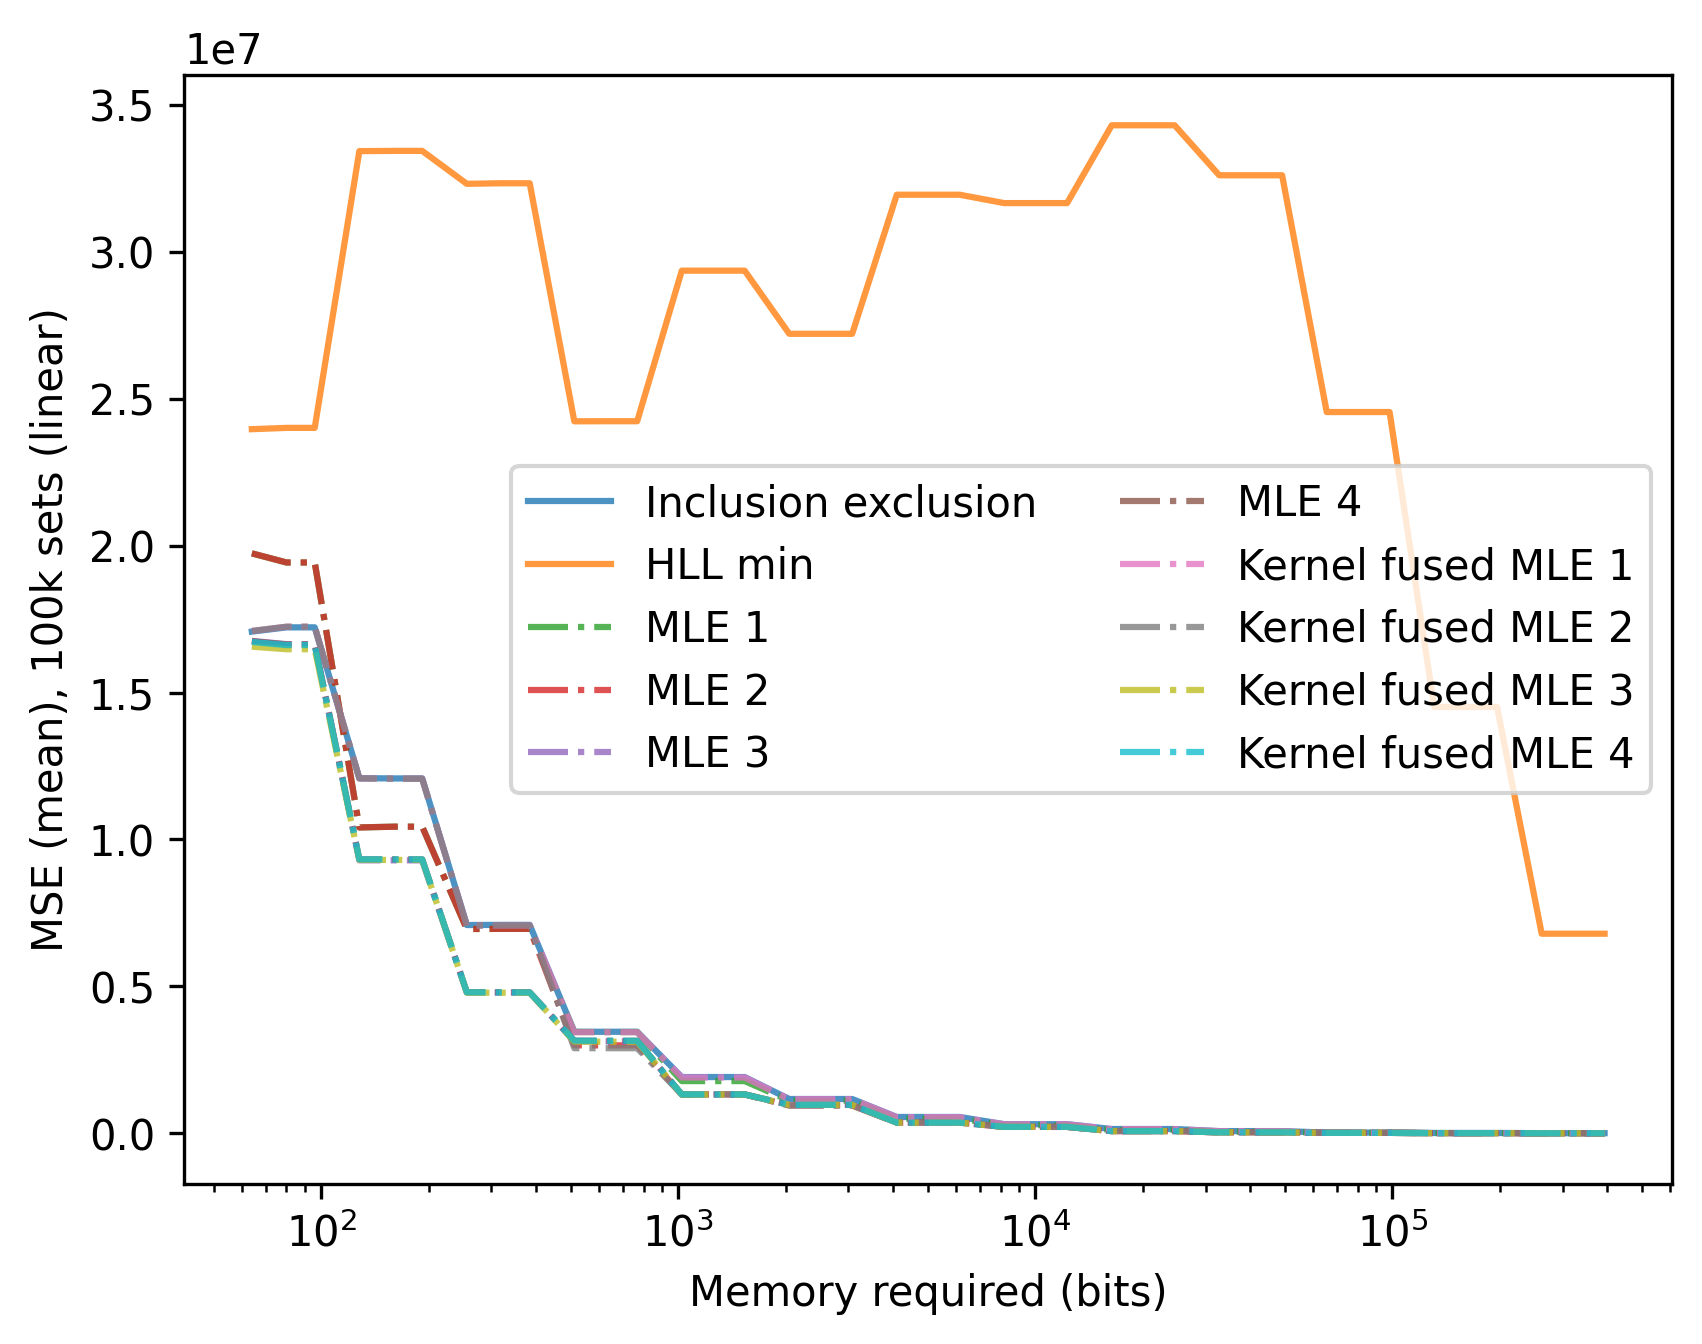

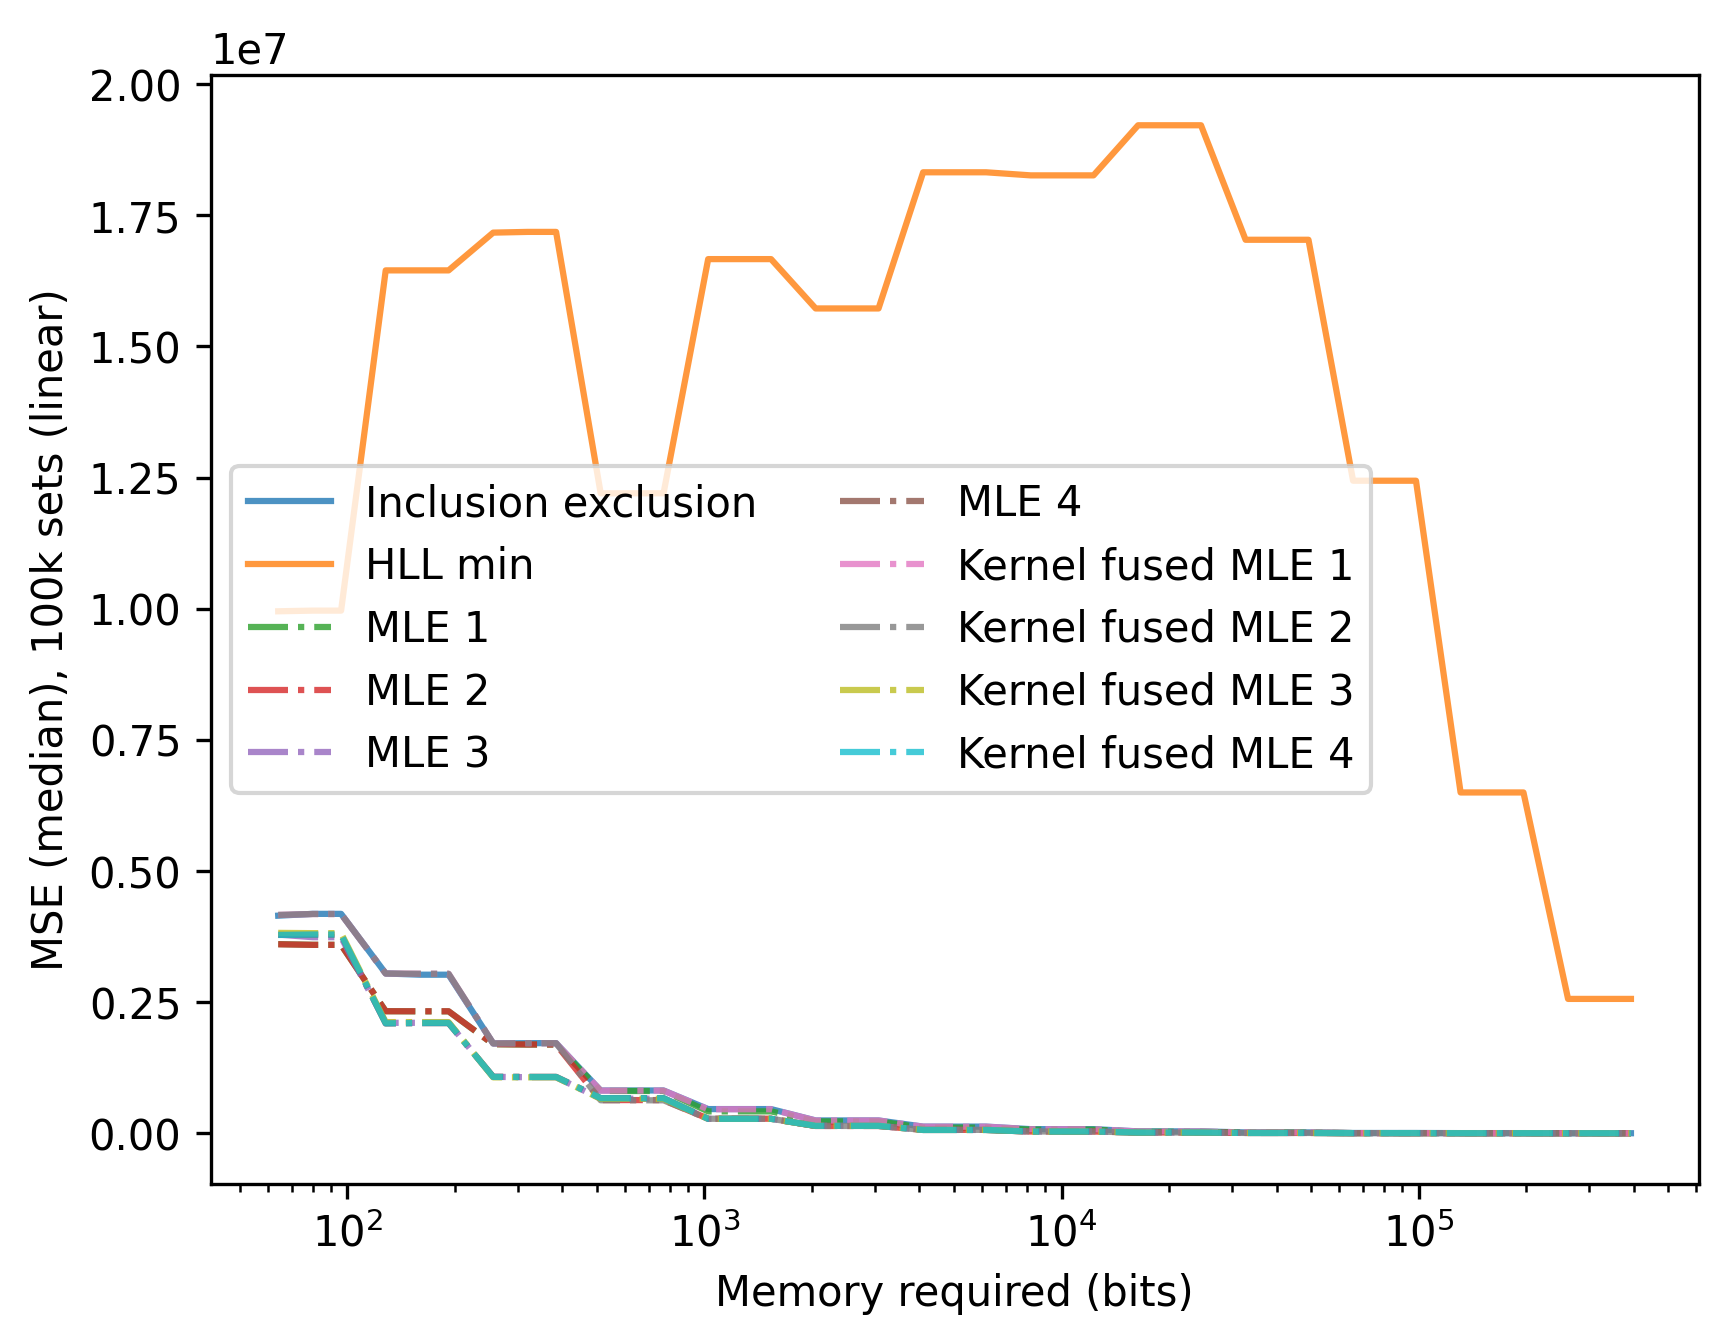

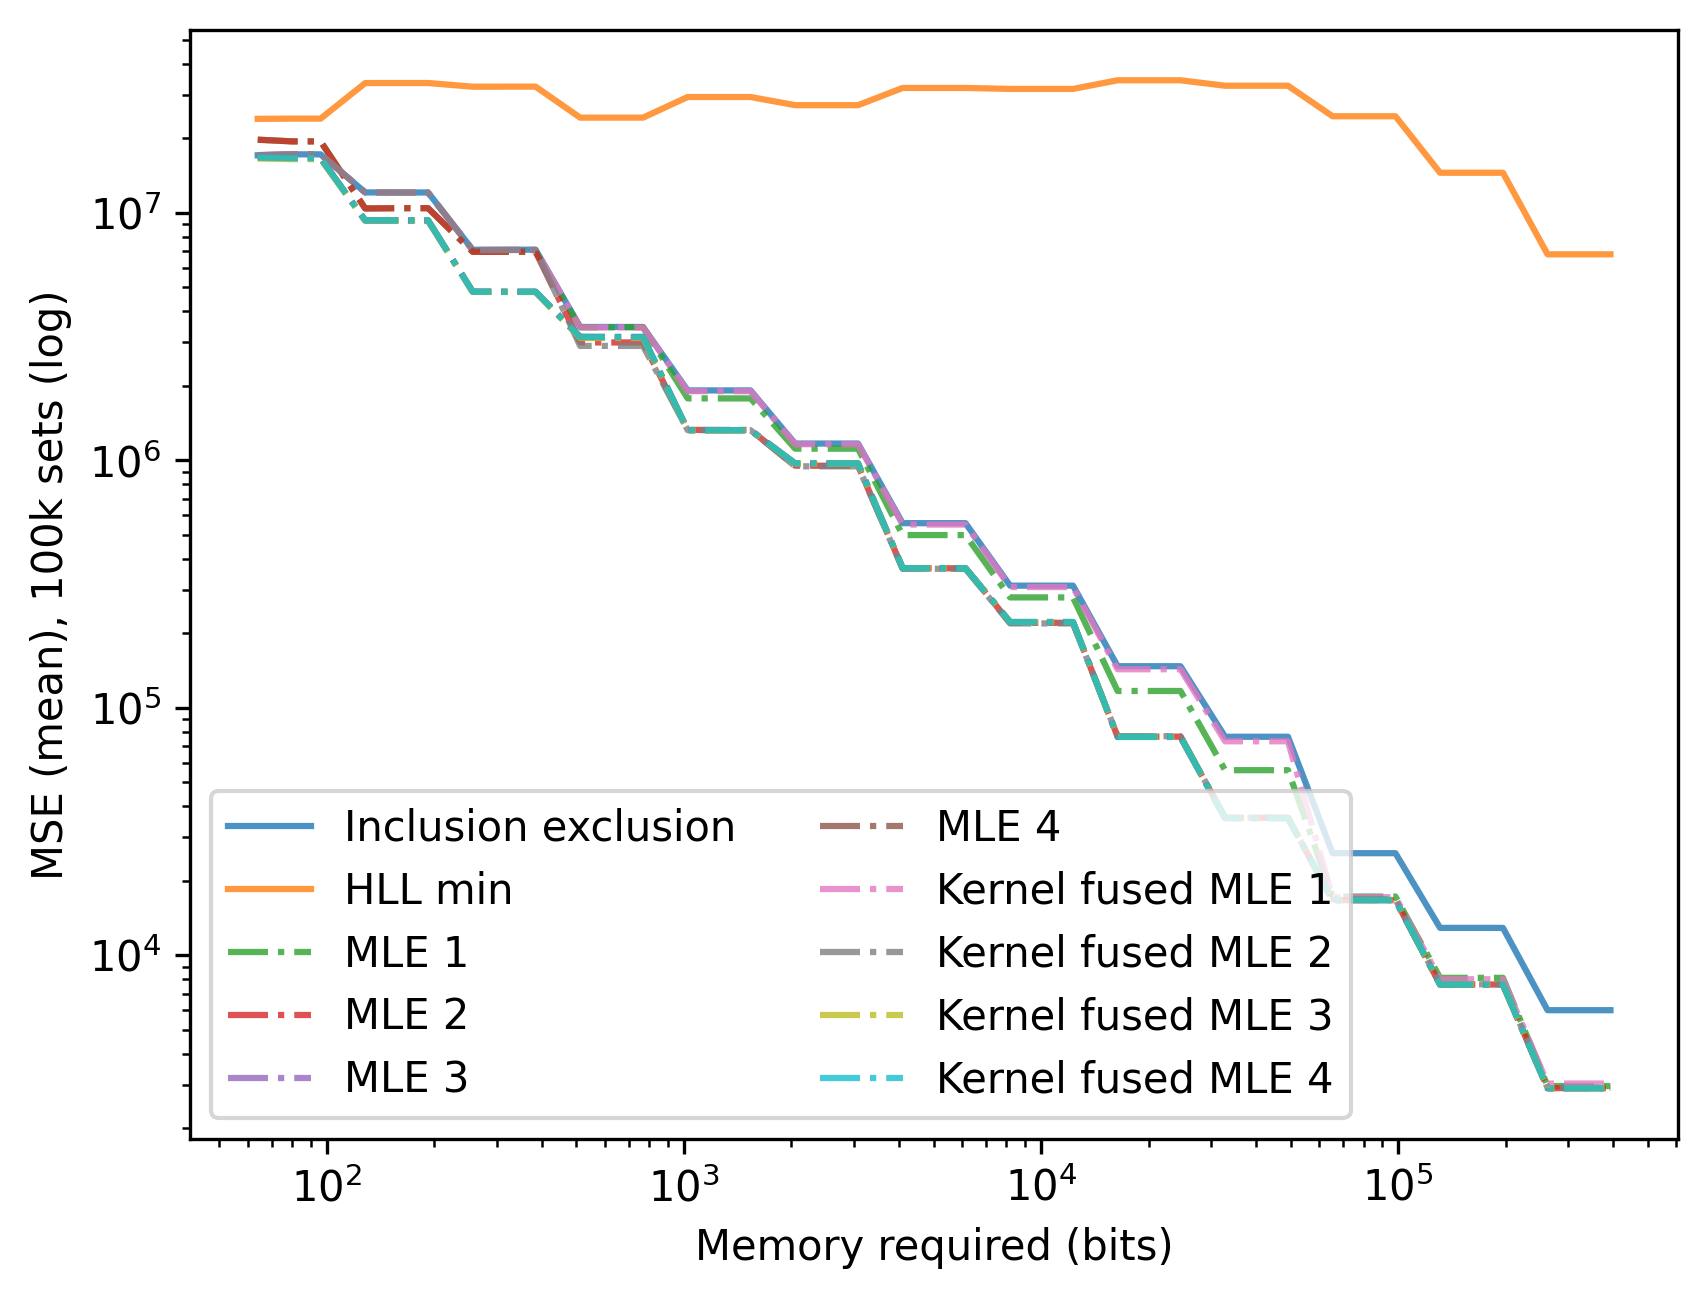

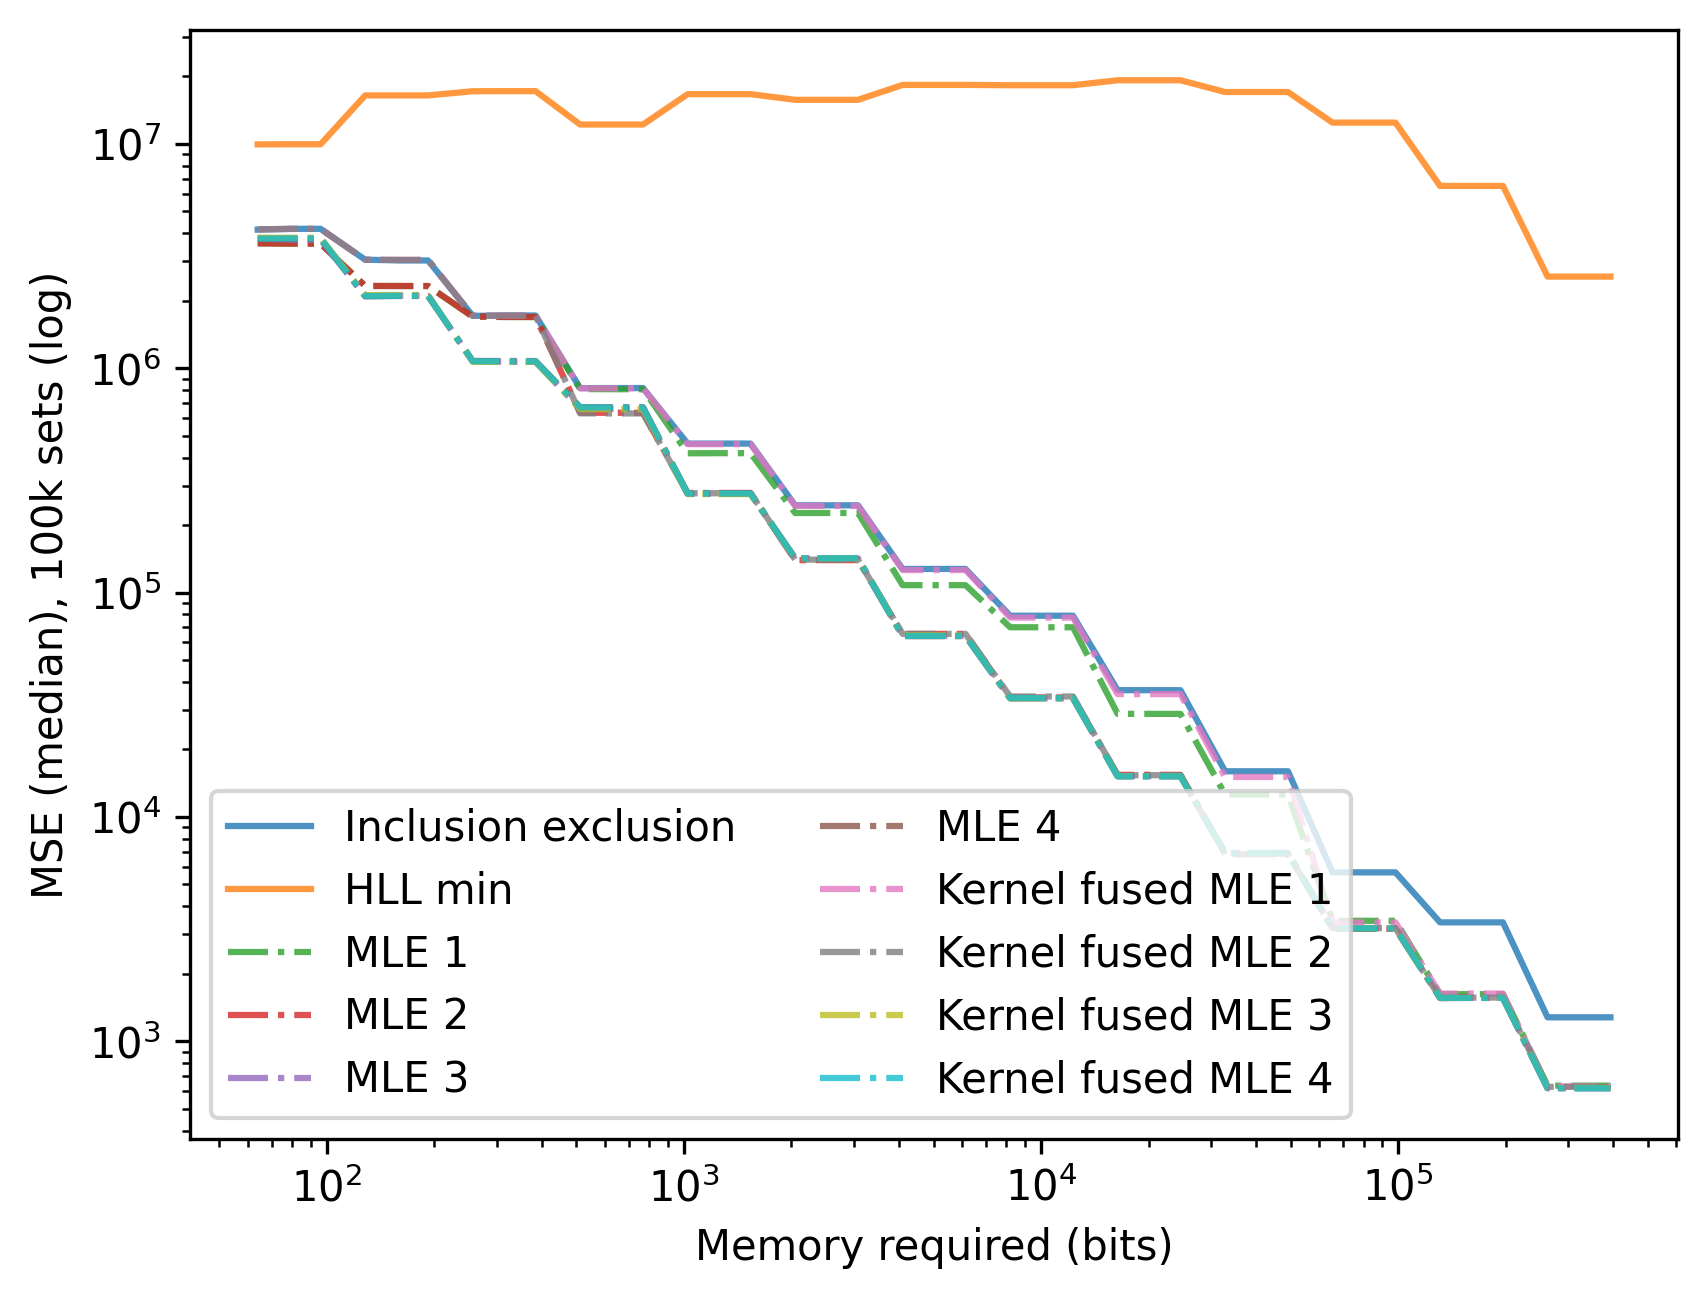

In [293]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (column, estimation) in zip(errors, estimations):
            plt.plot(
                data_hll.memory,
                data_hll[column][metric],
                ls='-.' if "mle" in estimation else "-",
                alpha=0.8,
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"MSE ({metric}), 100k sets ({yscale})")
        plt.xlabel("Memory required (bits)")
        plt.show()

## MSE per time requirements
Let's take a look at the performance of the methods when we consider the time requirements.

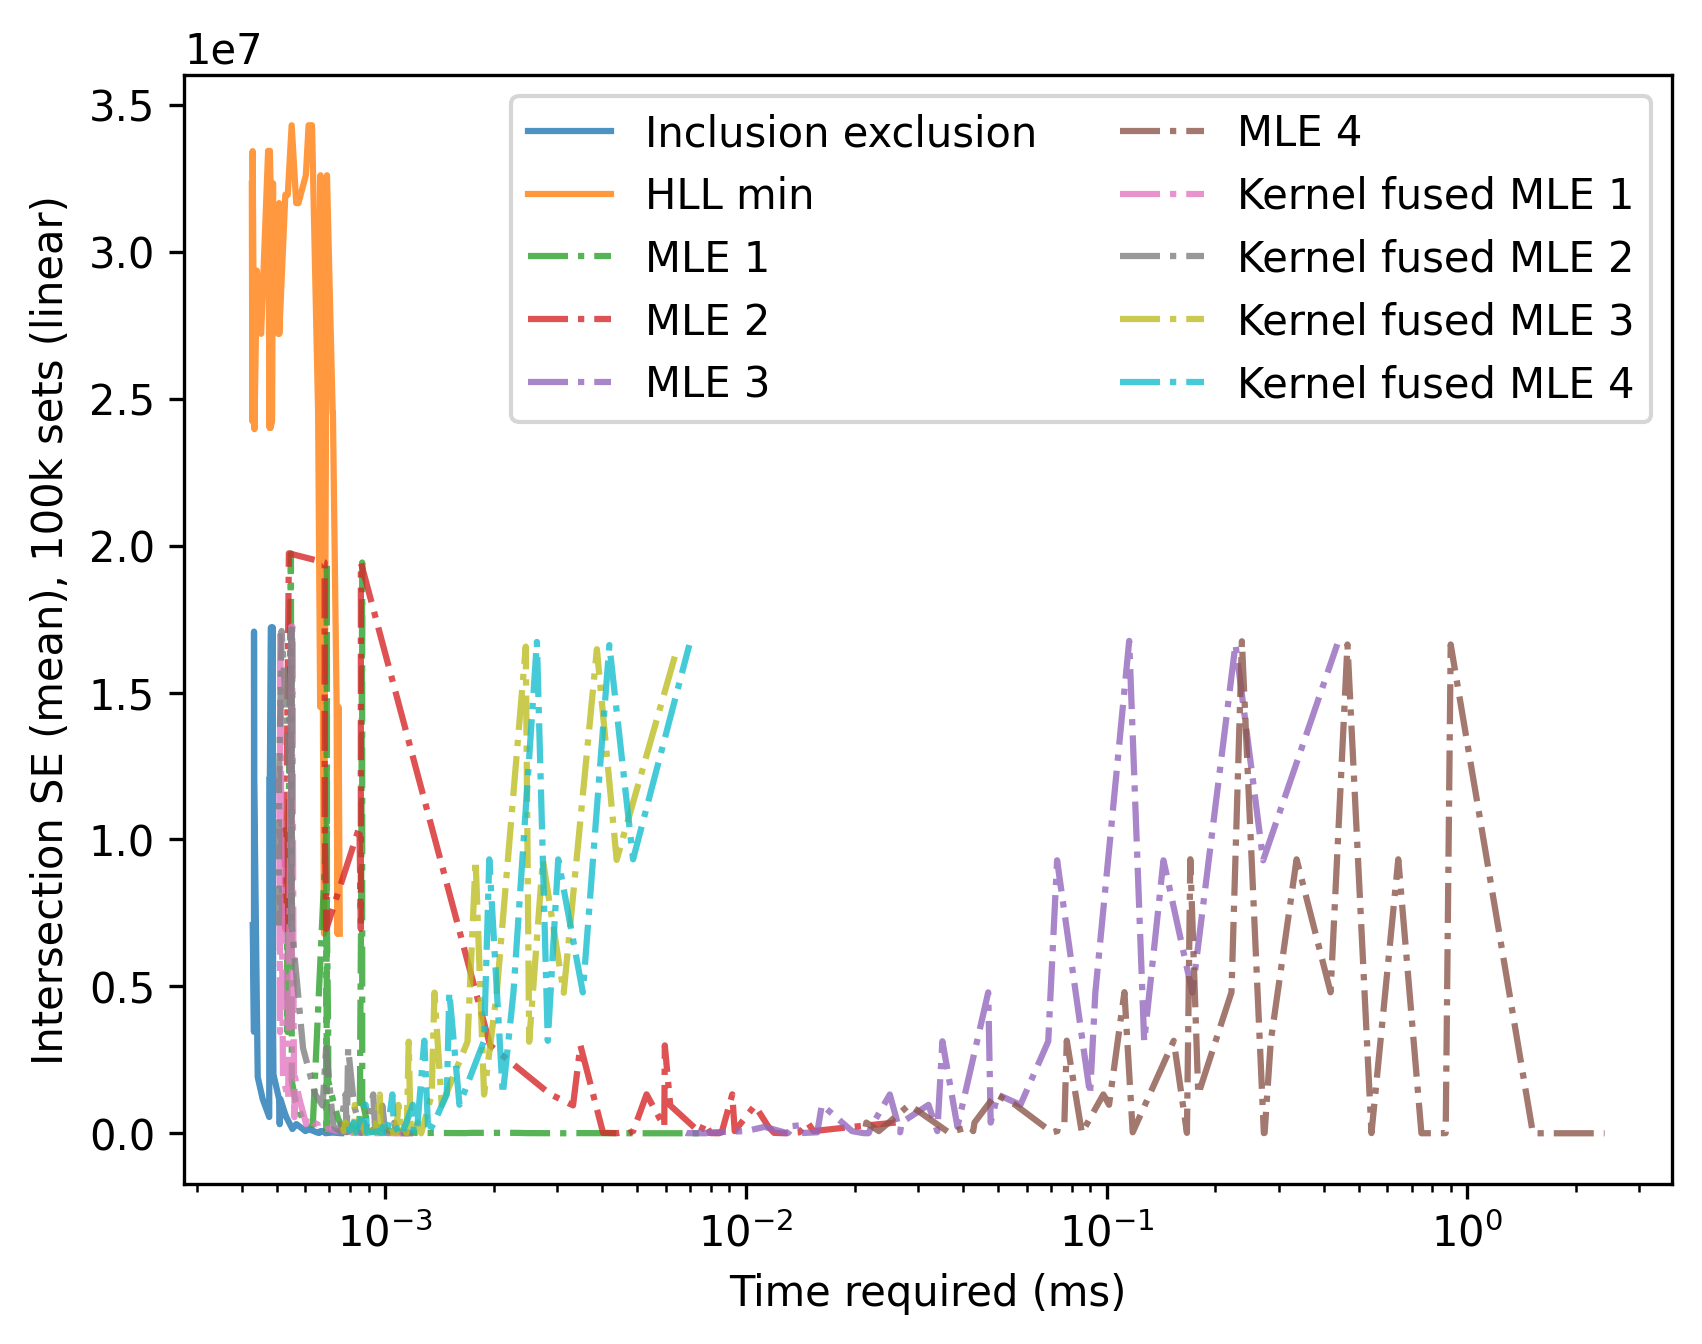

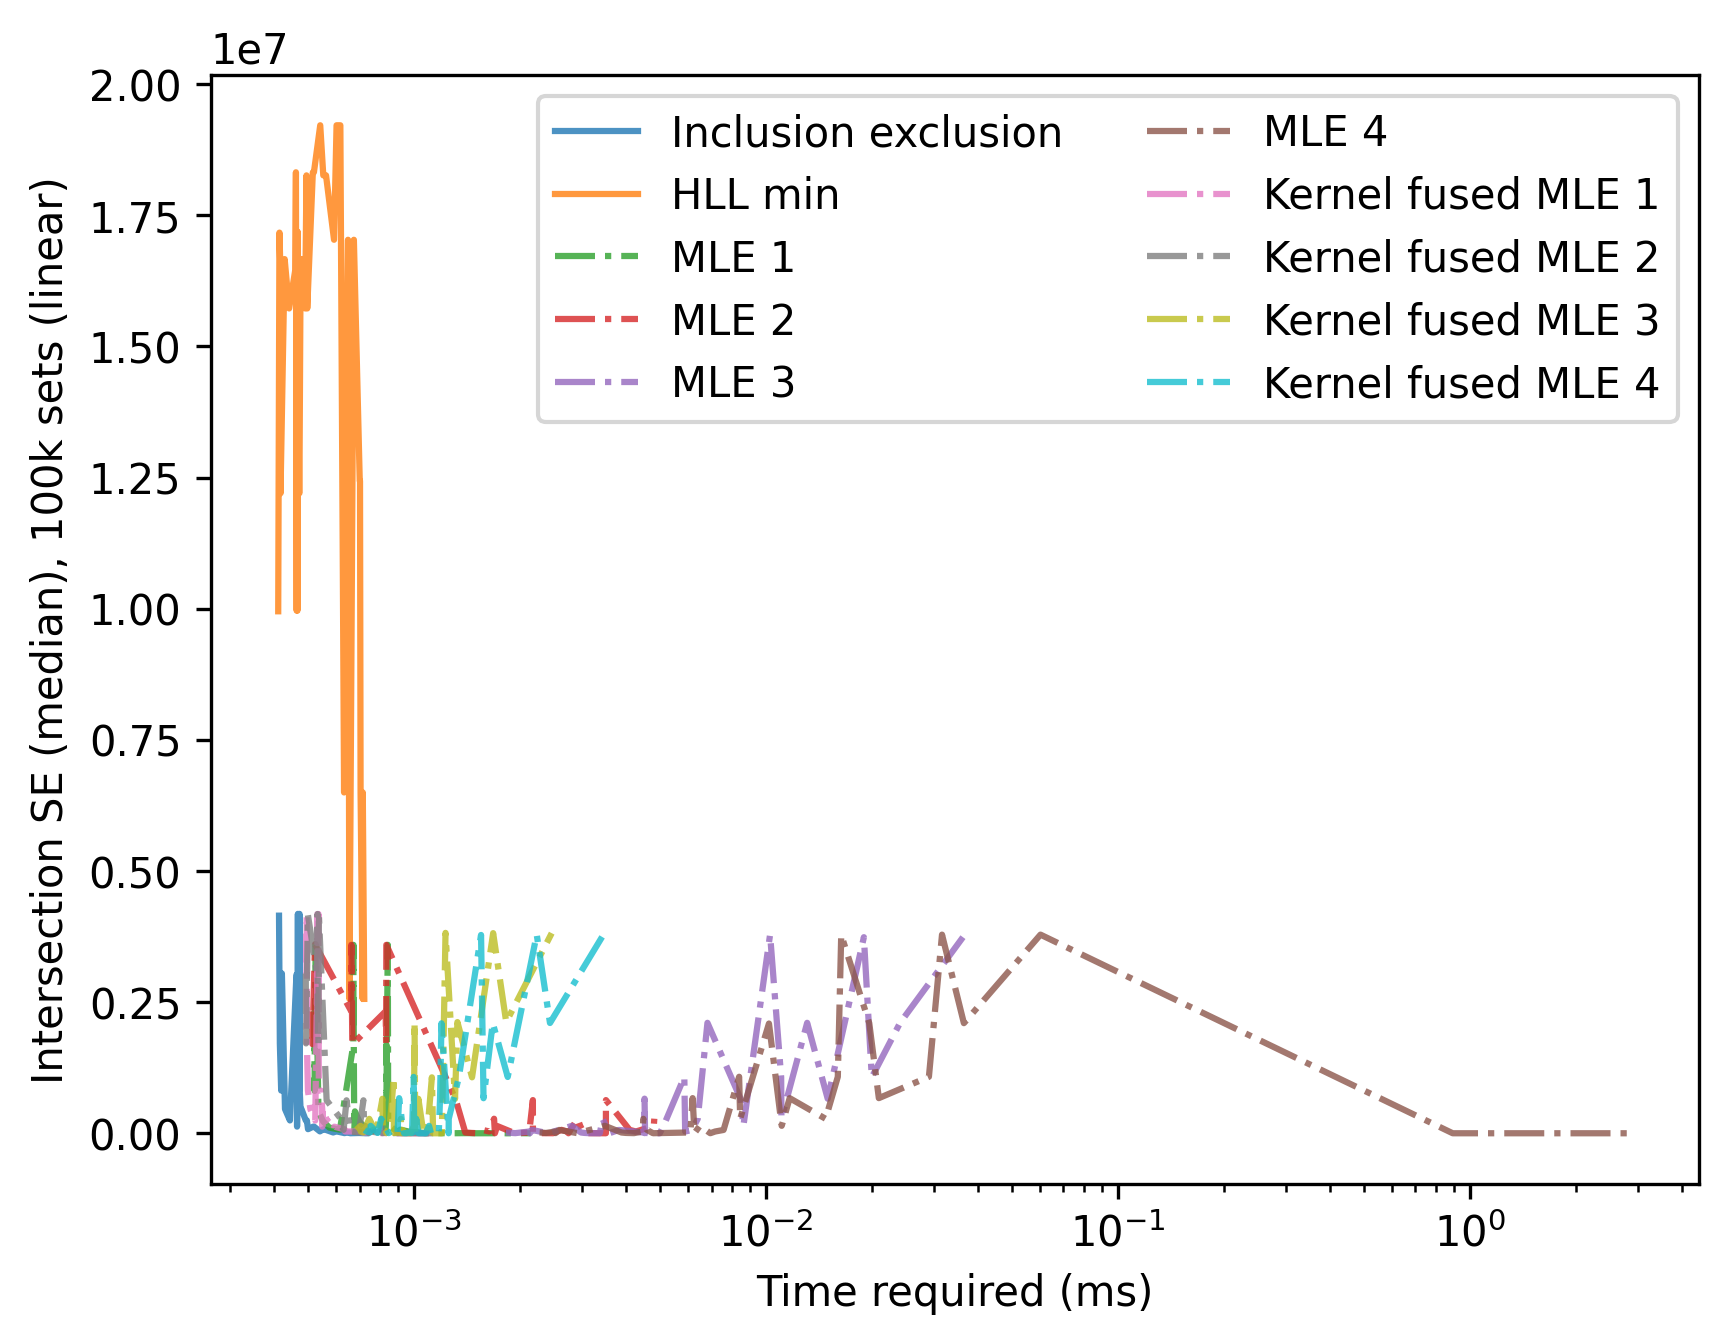

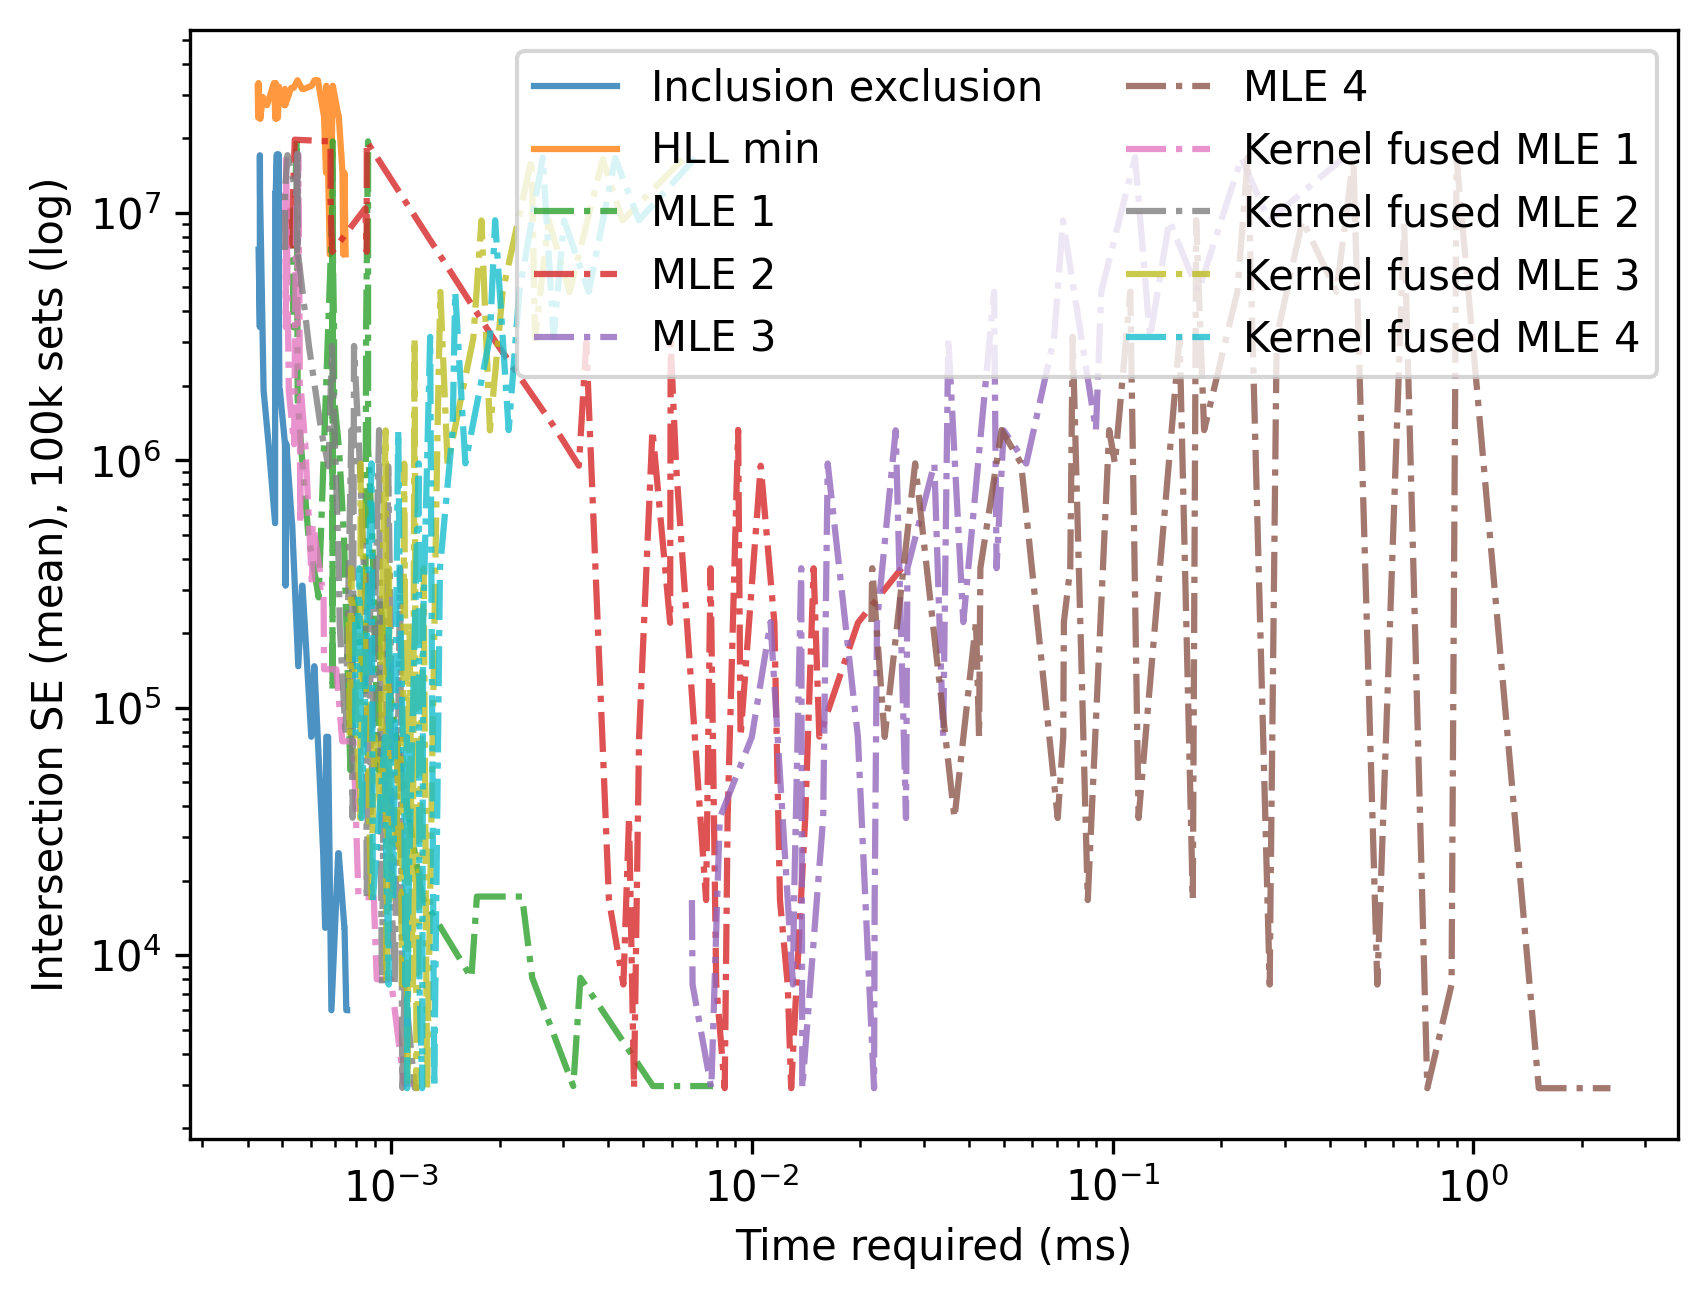

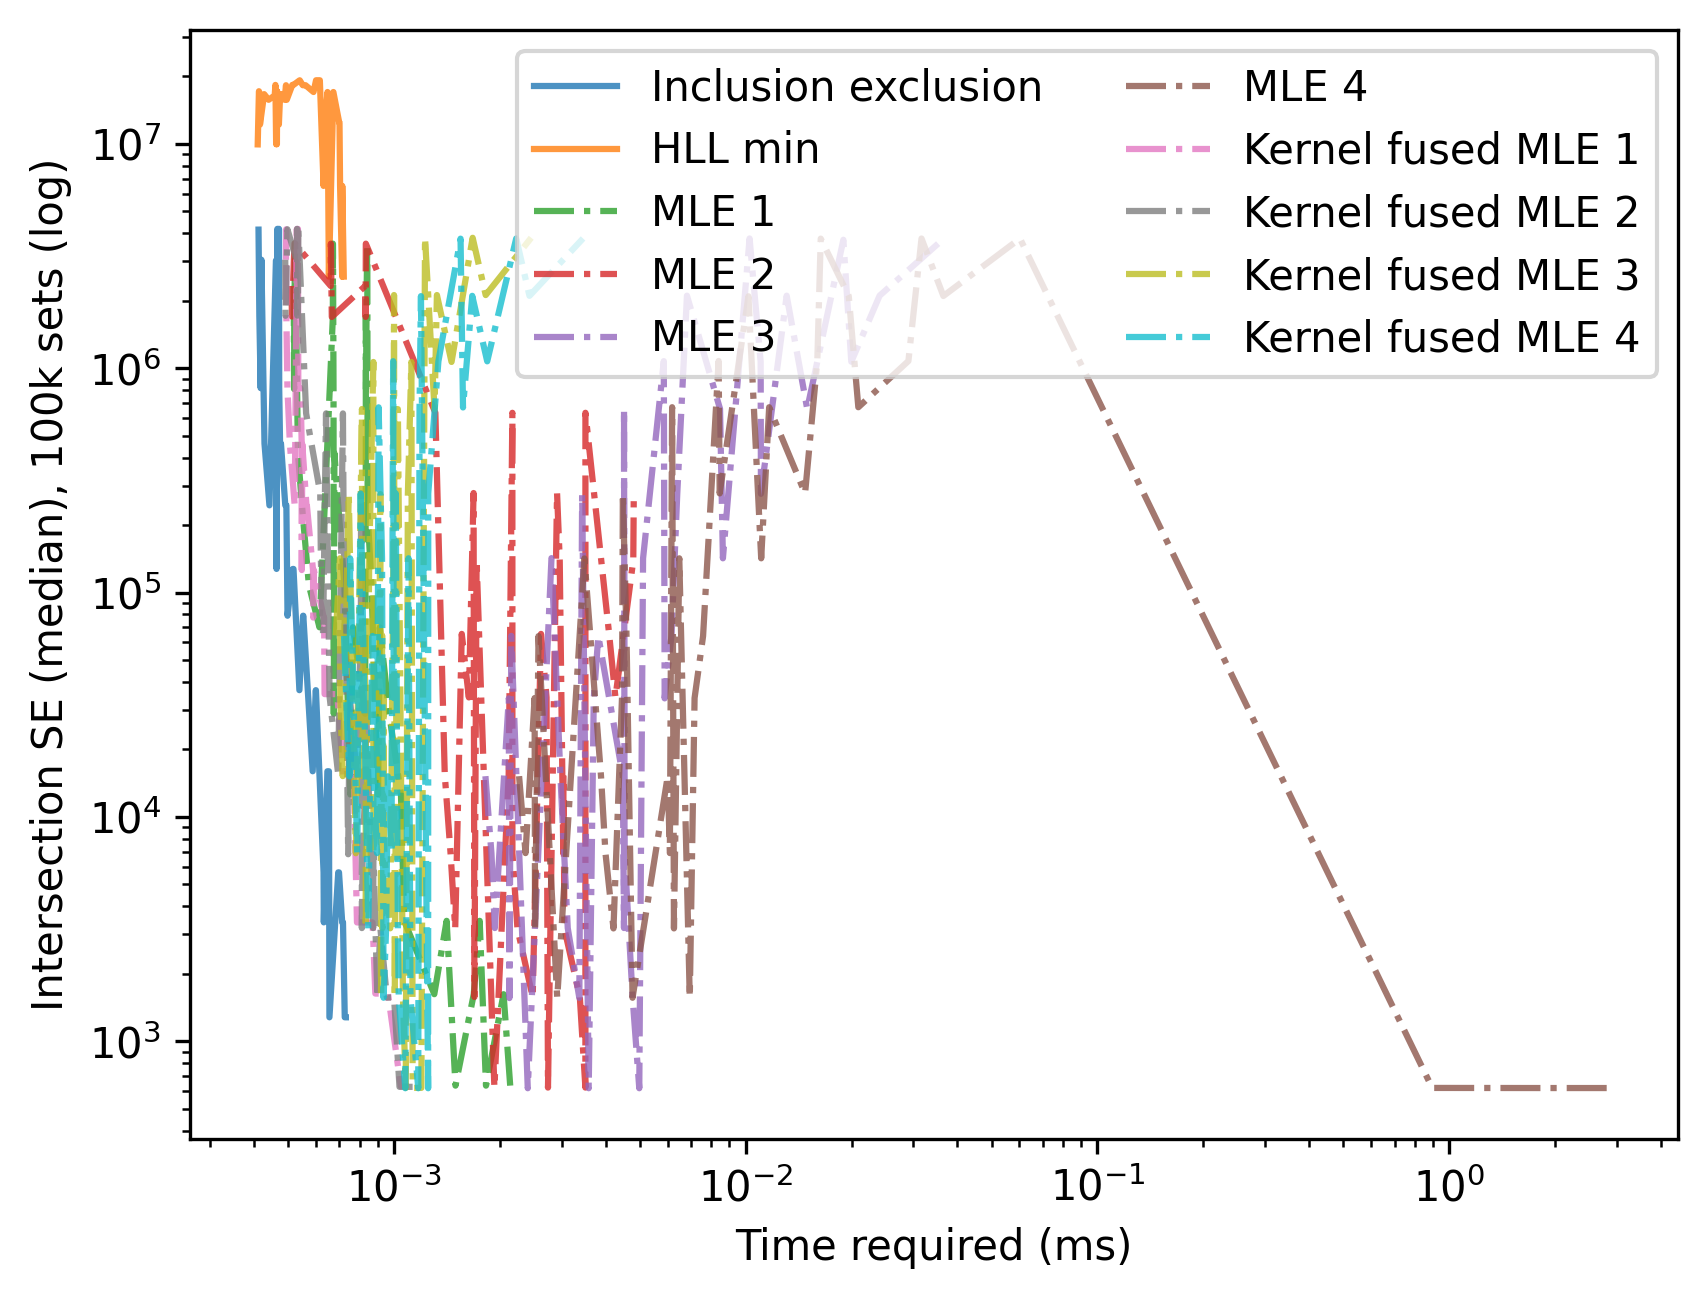

In [294]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (estimation, error_column) in zip(estimations, errors):
            time_column = f"time_{estimation}"
            sorted_data = data_hll.copy().sort_values((time_column, metric))

            time = sorted_data[time_column]

            plt.plot(
                time[metric],
                sorted_data[error_column][metric],
                alpha=0.8,
                ls=":" if "updated" in estimation else '-.' if "mle" in estimation else "-",
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"Intersection SE ({metric}), 100k sets ({yscale})")
        plt.xlabel("Time required (ms)")
        plt.show()

## MSE per times, multiplied by memory requirements
Let's take a look at the performance of the methods when we consider the time requirements multiplied by the memory requirements, so to have a more complete picture of the performance of the methods.

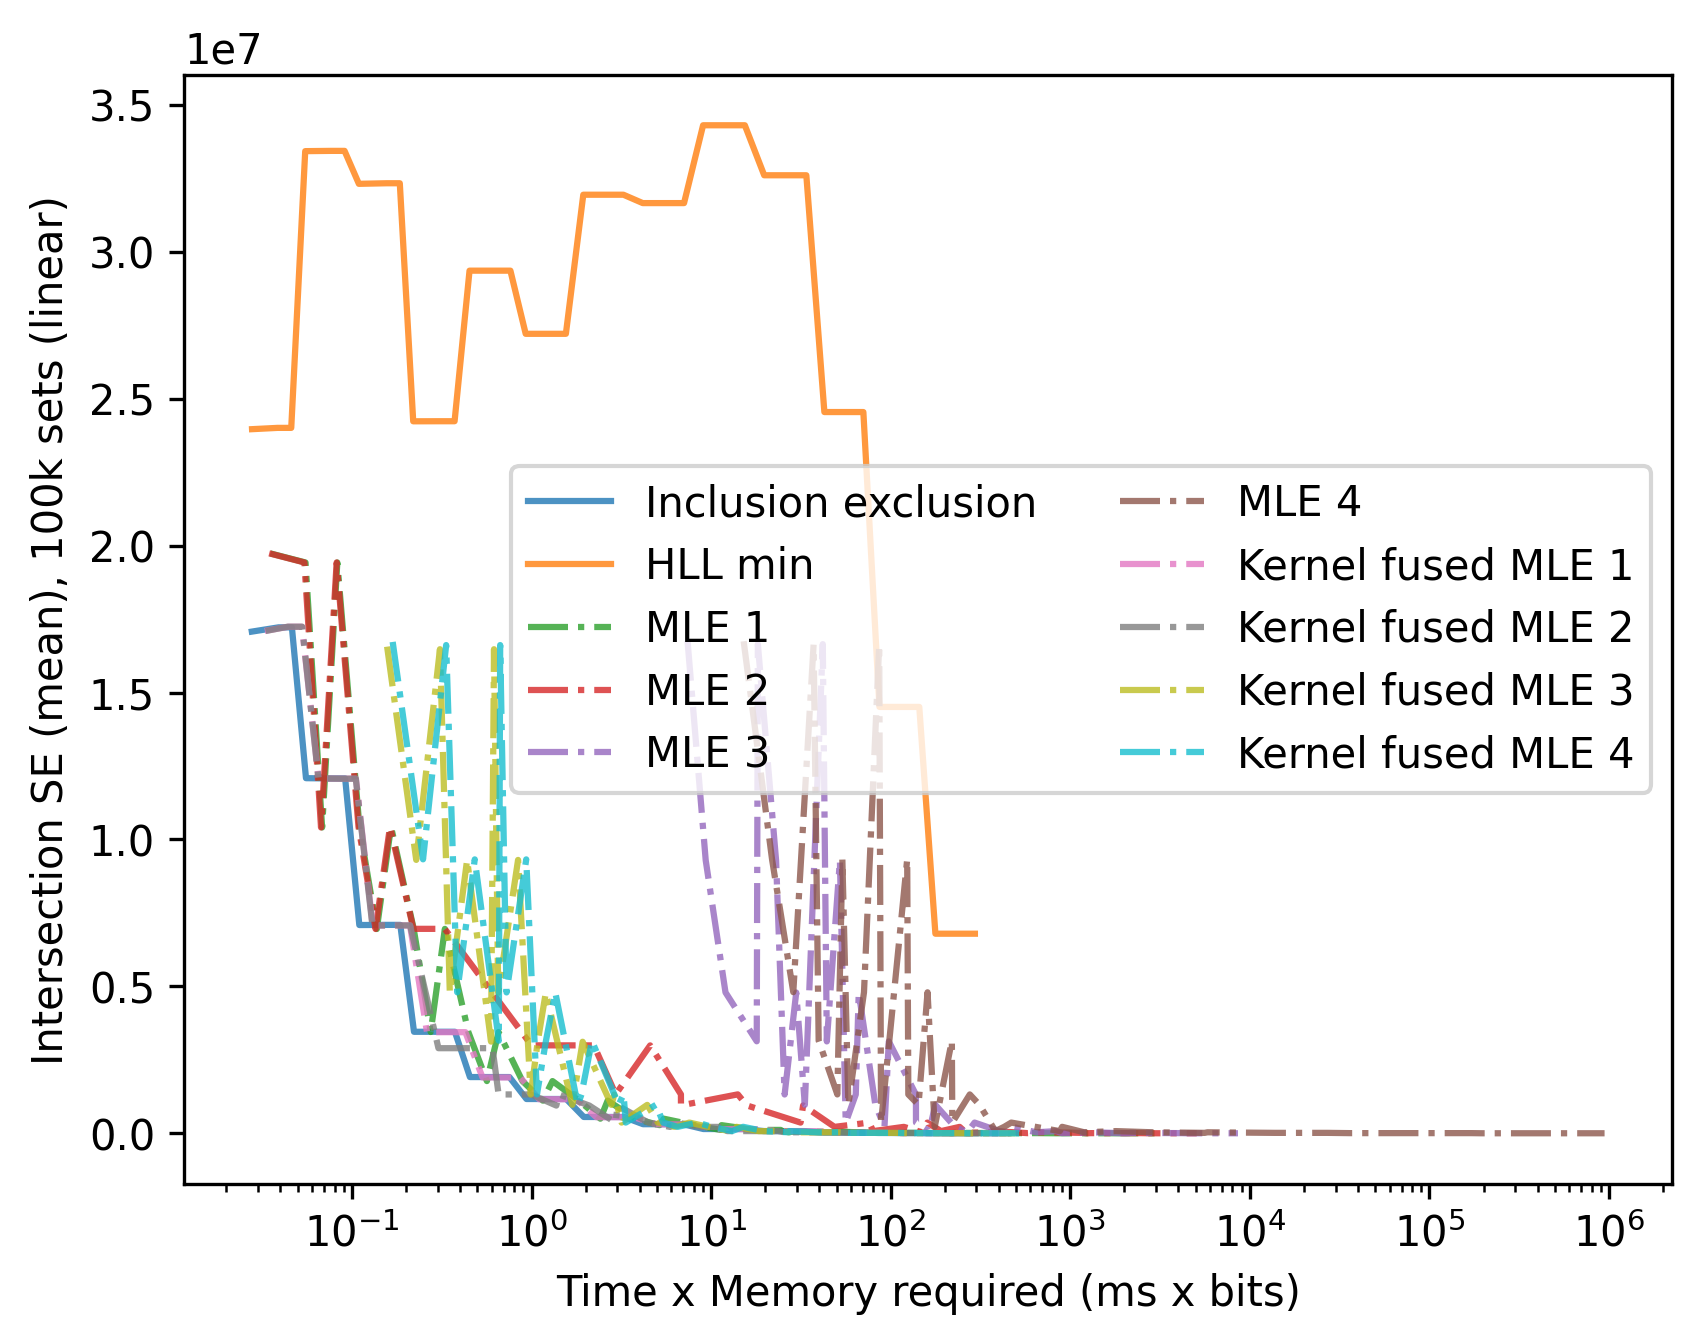

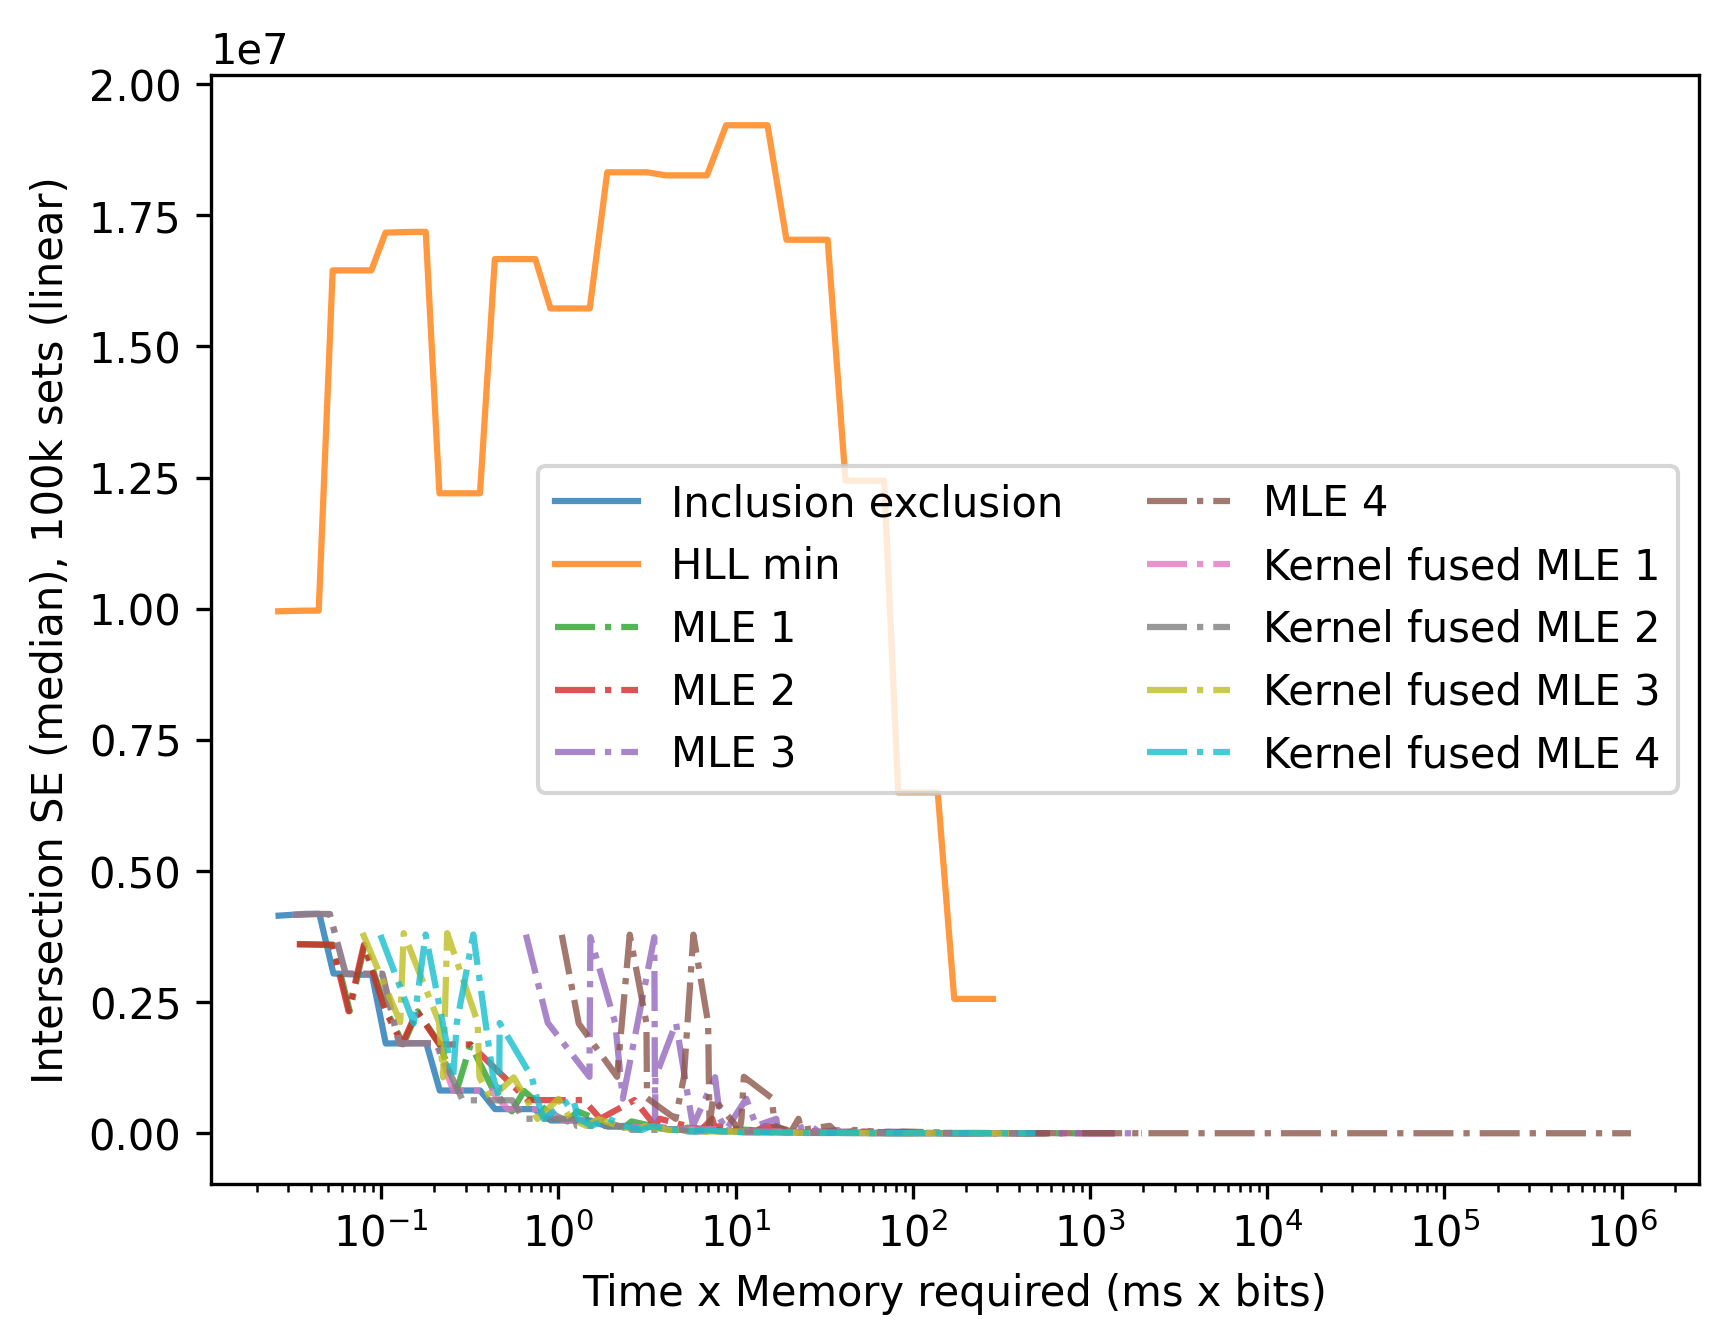

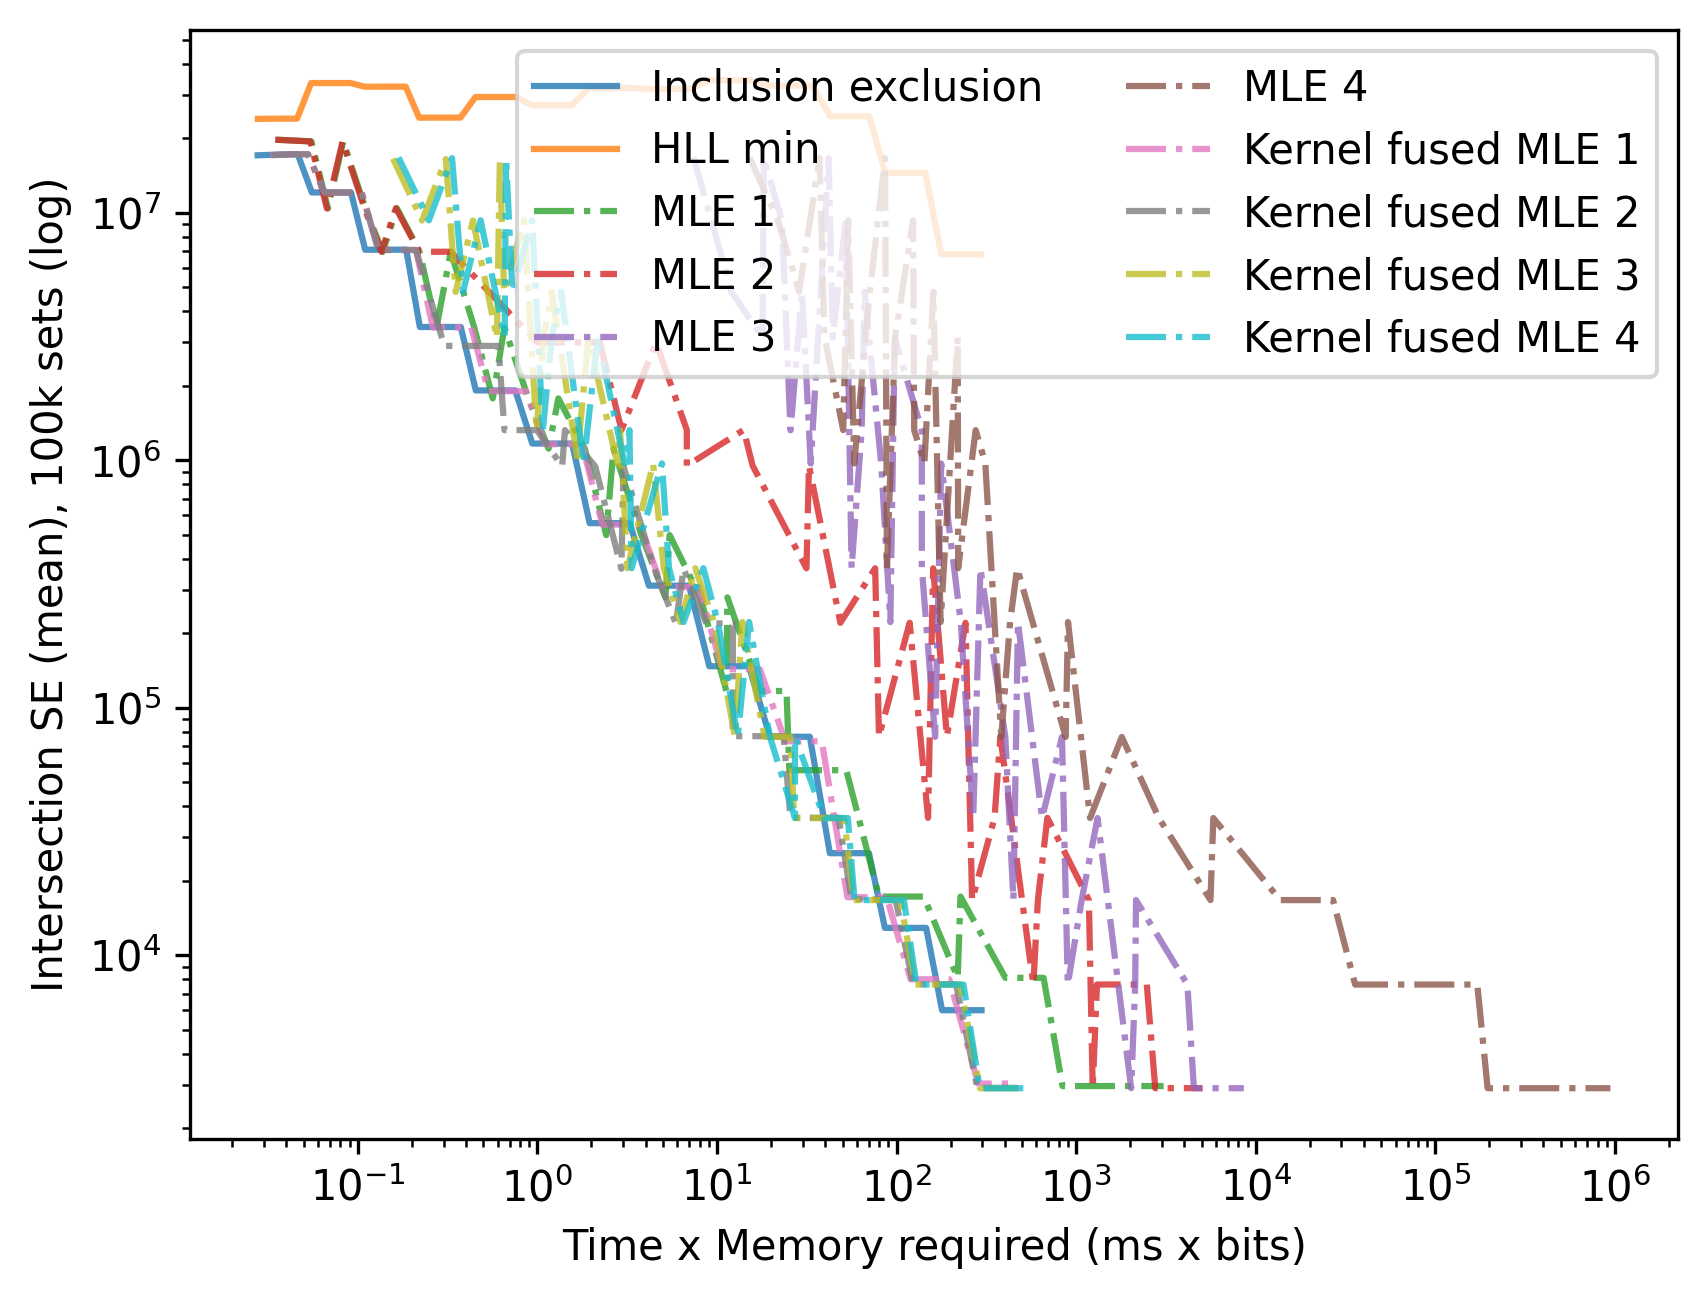

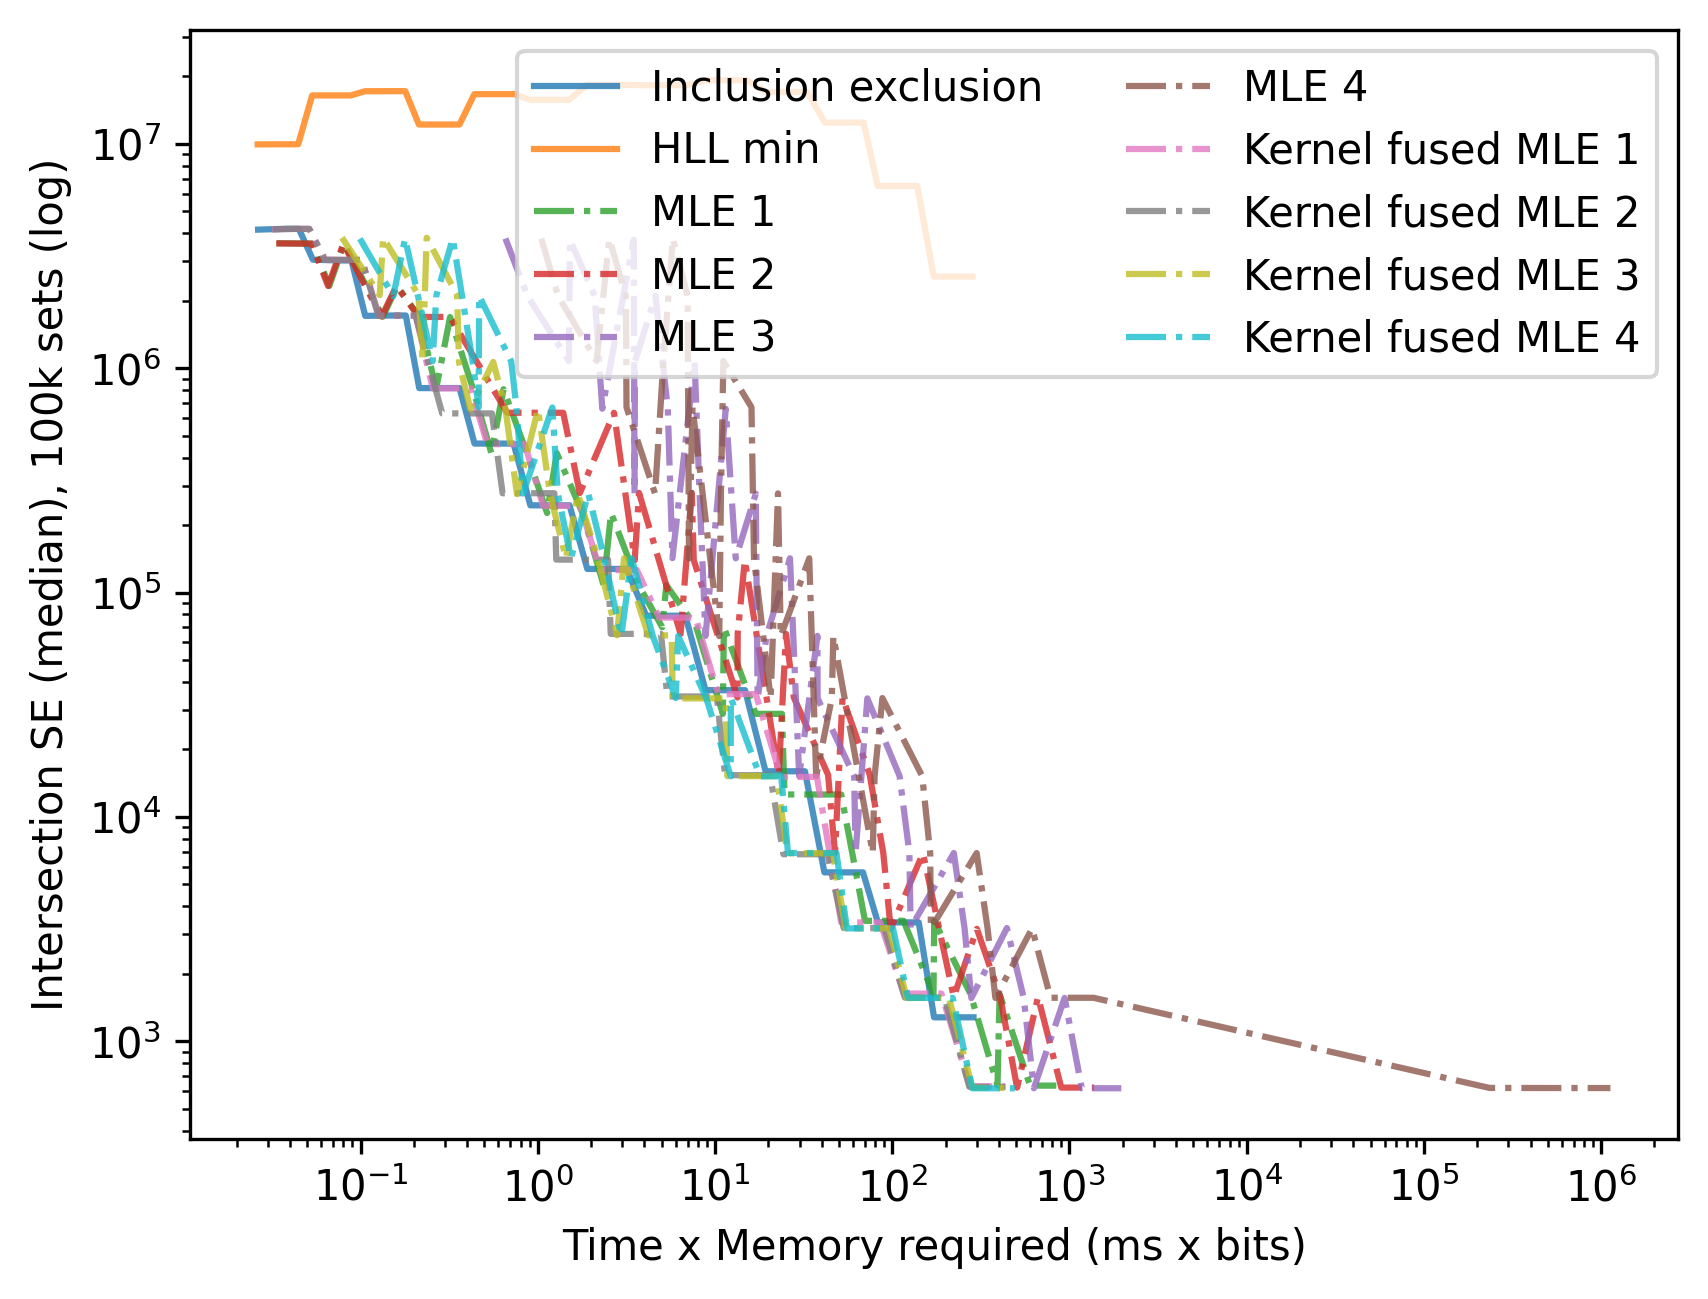

In [295]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (estimation, error_column) in zip(estimations, errors):
            time_column = f"time_{estimation}"

            data_hll["combined"] = data_hll[time_column][metric] * data_hll.memory
            data_hll = data_hll.sort_values("combined")

            plt.plot(
                data_hll["combined"],
                data_hll[error_column][metric],
                alpha=0.8,
                ls=":" if "updated" in estimation else '-.' if "mle" in estimation else "-",
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"Intersection SE ({metric}), 100k sets ({yscale})")
        plt.xlabel("Time x Memory required (ms x bits)")
        plt.show()

## Conclusion
We have explored three different methods to estimate the intersection of two sets using HyperLogLog counters. The first method is usually referred to as inclusion-exclusion principle, the second method computes a new HyperLogLog counter from the minimum of the two counters (somewhat inspired by how MinHash operates) and the third method uses the Maximum Likelihood Estimation (MLE) to have a better estimate of the intersection cardinality. We have seen that the MLE method is the most accurate, but it is also the slowest. The inclusion-exclusion principle is the fastest, but it is less accurate than the MLE method.

The minimum of two counters is the worst performing method, by far. We have also seen that **the MLE method is up to twice as accurate as the inclusion-exclusion principle**, and in average it is $1.5$ times more accurate. The MLE method is up to $900$ and $77$ times slower than the inclusion-exclusion method in mean and median respectively. The MLE method is at least $10$ and $3$ times slower than the inclusion-exclusion method in mean and median respectively. Finally, the MLE method is, in median, at least $55$ and $7$ times slower than the inclusion-exclusion method in mean and median respectively.

The MLE method may be employed in use cases where the accuracy of the estimate is more important than the time required to compute the estimate. The inclusion-exclusion principle may be employed in use cases where the time required to compute the estimate is more important than the accuracy of the estimate. When used, the MLE method should be employed with an error threshold of $3$, as it provides the best trade-off between accuracy and time requirements.

The minimum of two counters should not ever be employed, as it is the worst performing method.

Thank you for reading this notebook, I hope you found it interesting! Consider [following me on LinkedIn for more similar tutorials](https://www.linkedin.com/in/lucacappelletti94/).

And don't forget to [start the repository](https://github.com/LucaCappelletti94/hyperloglog-rs)!

## References
- [HyperLogLog in Practice: Algorithmic Engineering of a State of The Art Cardinality Estimation Algorithm](https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/40671.pdf)
- [HyperLogLog in Rust](https://github.com/LucaCappelletti94/hyperloglog-rs)
- [MinHash in Rust](https://github.com/LucaCappelletti94/minhash-rs)